In [1]:
# 구글 드라이브 입력
#from google.colab import drive
#drive.mount('/content/gdrive/')

설치 해야하는 것들 및 함수들

In [2]:
# pip install 요소들 정리
# annoy는 반드시 visual studio build tools 설치
#! pip install -q annoy
#! pip install -q FRUFS
#! pip install -q pacmap

In [3]:
# import할 요소들 정리
import copy
import pandas as pd
import numpy as np
import warnings
import pacmap

from FRUFS import FRUFS
from lightgbm import LGBMRegressor

from sklearn.ensemble import IsolationForest

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import matplotlib.pyplot as plt

import os

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

from scipy.stats import ranksums

# 파일 위치 고정
os.chdir("open")

# Train dataset
train_df = pd.read_csv('train.csv')
train_df = train_df.iloc[:,1:]

# Validation dataset
val_df = pd.read_csv('val.csv')
ori_val_df = val_df.iloc[:,1:]
val_class = val_df.iloc[:,31]
val_df = val_df.iloc[:,1:31]

# Test dataset
test_df = pd.read_csv('test.csv')
test_df = test_df.iloc[:,1:]

warnings.filterwarnings(action='ignore')

In [4]:
# =========================
# [VIZ-CHECK 00] 공통 유틸 / 저장 폴더
# Insert AFTER cell [4]
# =========================
import os, re, json, math, time, shutil, hashlib
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score,
    roc_auc_score, precision_recall_curve, roc_curve, auc
)

# scipy가 있으면 drift 통계에 사용 (없어도 동작)
try:
    from scipy.stats import ks_2samp, wasserstein_distance
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
VIZ_ROOT = Path("./viz_checkpoints") / RUN_TAG
(VIZ_ROOT / "fig").mkdir(parents=True, exist_ok=True)
(VIZ_ROOT / "tables").mkdir(parents=True, exist_ok=True)
(VIZ_ROOT / "arrays").mkdir(parents=True, exist_ok=True)
(VIZ_ROOT / "logs").mkdir(parents=True, exist_ok=True)
(VIZ_ROOT / "backup").mkdir(parents=True, exist_ok=True)

print("✅ VIZ_ROOT =", VIZ_ROOT.resolve())

def _save_json(obj, relpath: str):
    p = VIZ_ROOT / relpath
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    return p

def _save_csv(df: pd.DataFrame, relpath: str, index=False):
    p = VIZ_ROOT / relpath
    p.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(p, index=index, encoding="utf-8-sig")
    return p

def _save_npy(arr: np.ndarray, relpath: str):
    p = VIZ_ROOT / relpath
    p.parent.mkdir(parents=True, exist_ok=True)
    np.save(p, arr)
    return p

def _save_fig(fig, relpath: str, dpi=180):
    p = VIZ_ROOT / relpath
    p.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(p, dpi=dpi, bbox_inches="tight")
    return p

def _md5_file(path: str):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def _feature_cols(df: pd.DataFrame):
    cols = [c for c in df.columns if re.match(r"^V\d+$", str(c))]
    if not cols:
        cols = [c for c in df.columns if str(c).startswith("V")]
    return cols

def _pos_rate(x, thr=0.5):
    x = np.asarray(x).reshape(-1)
    # 이미 0/1이면
    u = set(np.unique(x[~np.isnan(x)]).tolist())
    if u.issubset({0,1}):
        return float(np.mean(x == 1))
    # 0~1 voting이면
    return float(np.mean(x >= thr))

def _to_binary_pred(x, thr=0.5):
    x = np.asarray(x).reshape(-1)
    u = set(np.unique(x[~np.isnan(x)]).tolist())
    if u.issubset({0,1}):
        return x.astype(int)
    # voting 평균 값 (0~1)
    return (x >= thr).astype(int)

def _scatter2d(X, title, color=None):
    X = np.asarray(X)
    # 원본 코드가 [1,2,3] 사용하므로 2D는 [1,2] 우선
    if X.shape[1] > 2:
        x = X[:,1]; y = X[:,2]
    elif X.shape[1] == 2:
        x = X[:,0]; y = X[:,1]
    else:
        x = np.arange(len(X)); y = X[:,0]

    fig, ax = plt.subplots(figsize=(7,6))
    if color is None:
        ax.scatter(x, y, s=3)
    else:
        sc = ax.scatter(x, y, s=3, c=color)
        fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.set_xlabel("dim[1]" if X.shape[1] > 2 else "x")
    ax.set_ylabel("dim[2]" if X.shape[1] > 2 else "y")
    return fig

def _hist(arr, title, bins=60):
    arr = np.asarray(arr).reshape(-1)
    arr = arr[np.isfinite(arr)]
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(arr, bins=bins)
    ax.set_title(title)
    return fig

print("✅ VIZ utilities ready.")


✅ VIZ_ROOT = C:\Users\xrtwin\Desktop\신용카드 사기 거래 탐지 AI 경진대회 월간 데이콘\open\viz_checkpoints\20260112_114353
✅ VIZ utilities ready.



===== train_df =====
shape: (113842, 30) null_total: 0 dup_rows: 245
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
2 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
1  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
2  0.260314 -0.568671 -0.371407  ... -0.208254 -0.559825 -0.026398 -0.371427   

        V25       V26       V27       V28       V29       V30  
0 -0.327642 -0.139097 -0.055353 -0.059752  4.983721 -0.994972  
1  0.647376 -0.221929  0.062723  0.061458  1.418291 -0.994972  
2 -0.232794  0.105915  0.253844  0.081080 -0.256131 -0.994960  

[3 rows x 30 columns]


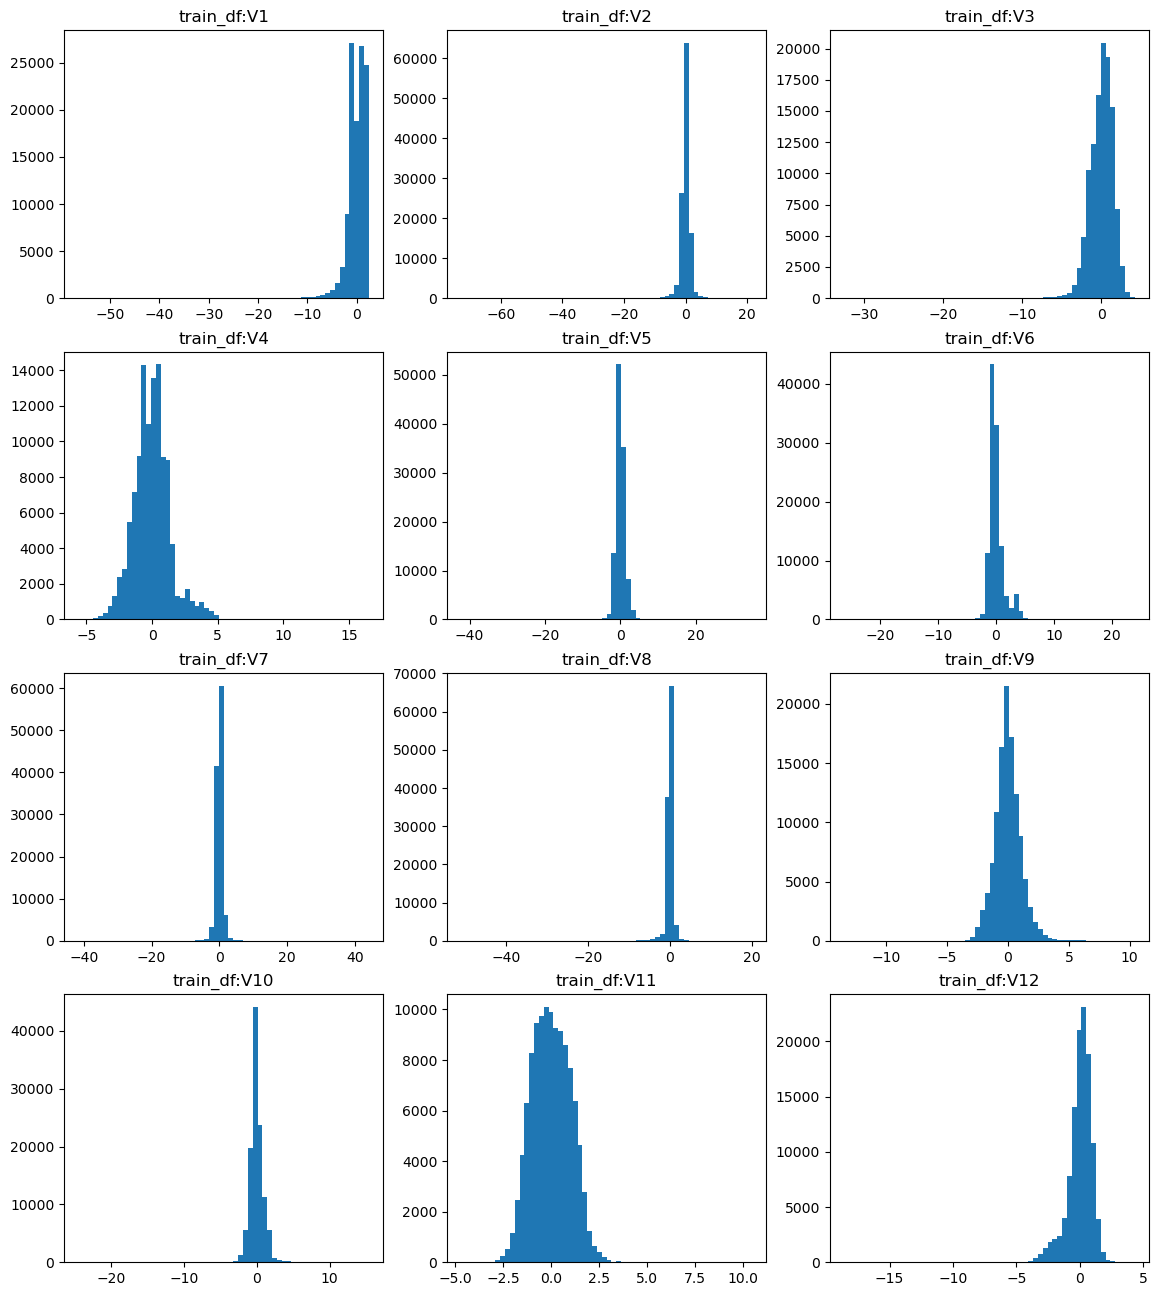

✅ saved: viz_checkpoints\20260112_114353\fig\train_df_raw_hist_top12.png

===== val_df =====
shape: (28462, 30) null_total: 0 dup_rows: 11
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   
1  0.962496  0.328461 -0.171479  2.109204  1.129566  1.696038  0.107712   
2  1.145524  0.575068  0.194008  2.598192 -0.092210 -1.044430  0.531588   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.069539 -0.736727 -0.366846  ... -0.246914 -0.633753 -0.120794 -0.385050   
1  0.521502 -1.191311  0.724396  ...  0.143997  0.402492 -0.048508 -1.371866   
2 -0.241888 -0.896287  0.757952  ...  0.011106 -0.119703 -0.076510  0.691320   

        V25       V26       V27       V28       V29       V30  
0 -0.069733  0.094199  0.246219  0.083076 -0.255991 -0.994878  
1  0.390814  0.199964  0.016371 -0.014605  0.168937 -0.994784  
2  0.633984  0.048741 -0.053192  0.016251  0.16

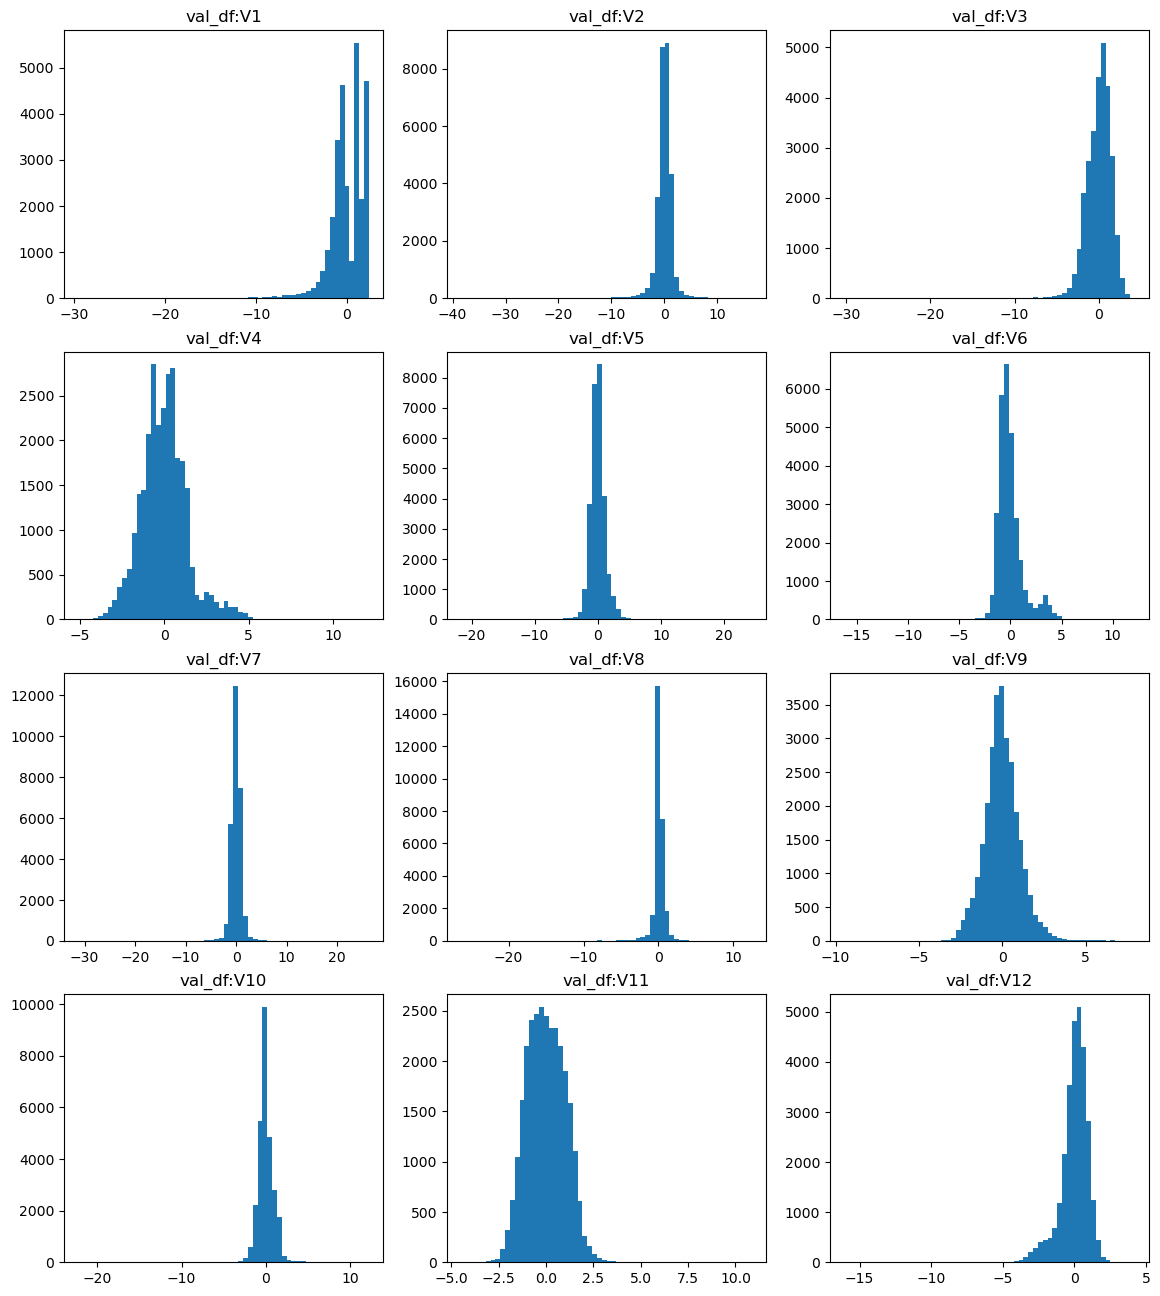

✅ saved: viz_checkpoints\20260112_114353\fig\val_df_raw_hist_top12.png

===== test_df =====
shape: (142503, 30) null_total: 0 dup_rows: 294
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28       V29       V30  
0  0.128539 -0.189115  0.133558 -0.021053  1.783274 -0.994983  
1  0.167170  0.125895 -0.008983  0.014724 -0.269825 -0.994983  
2 -0.206010  0.502292  0.219422  0.215153  0.6

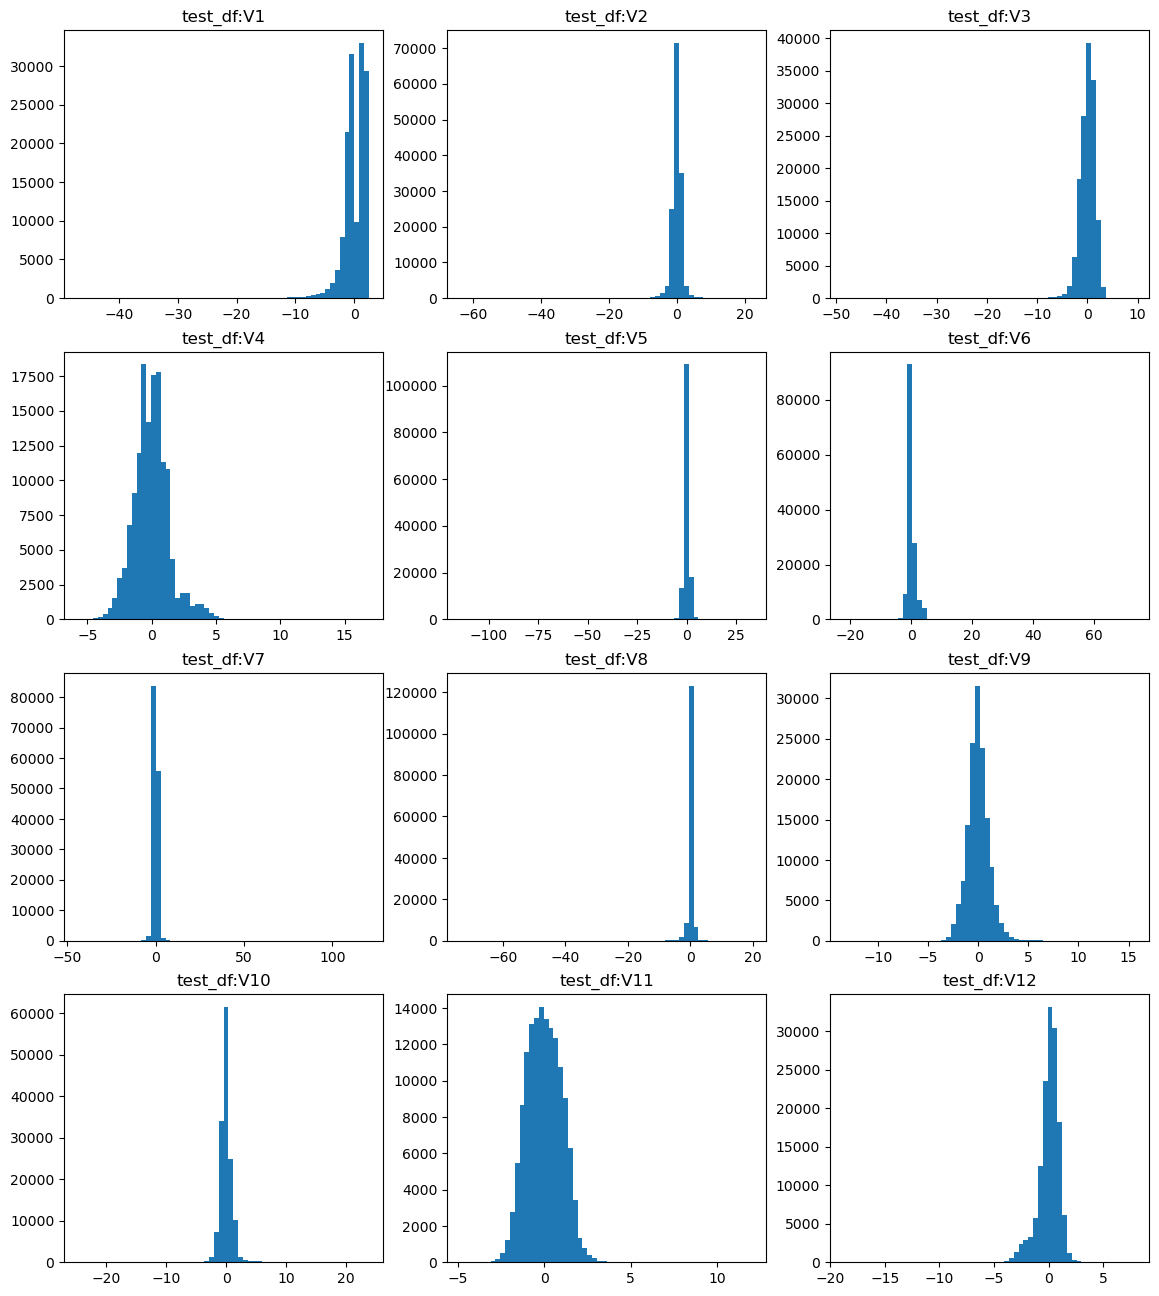

✅ saved: viz_checkpoints\20260112_114353\fig\test_df_raw_hist_top12.png

===== ori_val_df =====
shape: (28462, 31) null_total: 0 dup_rows: 11
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   
1  0.962496  0.328461 -0.171479  2.109204  1.129566  1.696038  0.107712   
2  1.145524  0.575068  0.194008  2.598192 -0.092210 -1.044430  0.531588   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.069539 -0.736727 -0.366846  ... -0.633753 -0.120794 -0.385050 -0.069733   
1  0.521502 -1.191311  0.724396  ...  0.402492 -0.048508 -1.371866  0.390814   
2 -0.241888 -0.896287  0.757952  ... -0.119703 -0.076510  0.691320  0.633984   

        V26       V27       V28       V29       V30  Class  
0  0.094199  0.246219  0.083076 -0.255991 -0.994878      0  
1  0.199964  0.016371 -0.014605  0.168937 -0.994784      0  
2  0.048741 -0.053192  0.016251  0.169496 -0.994502  

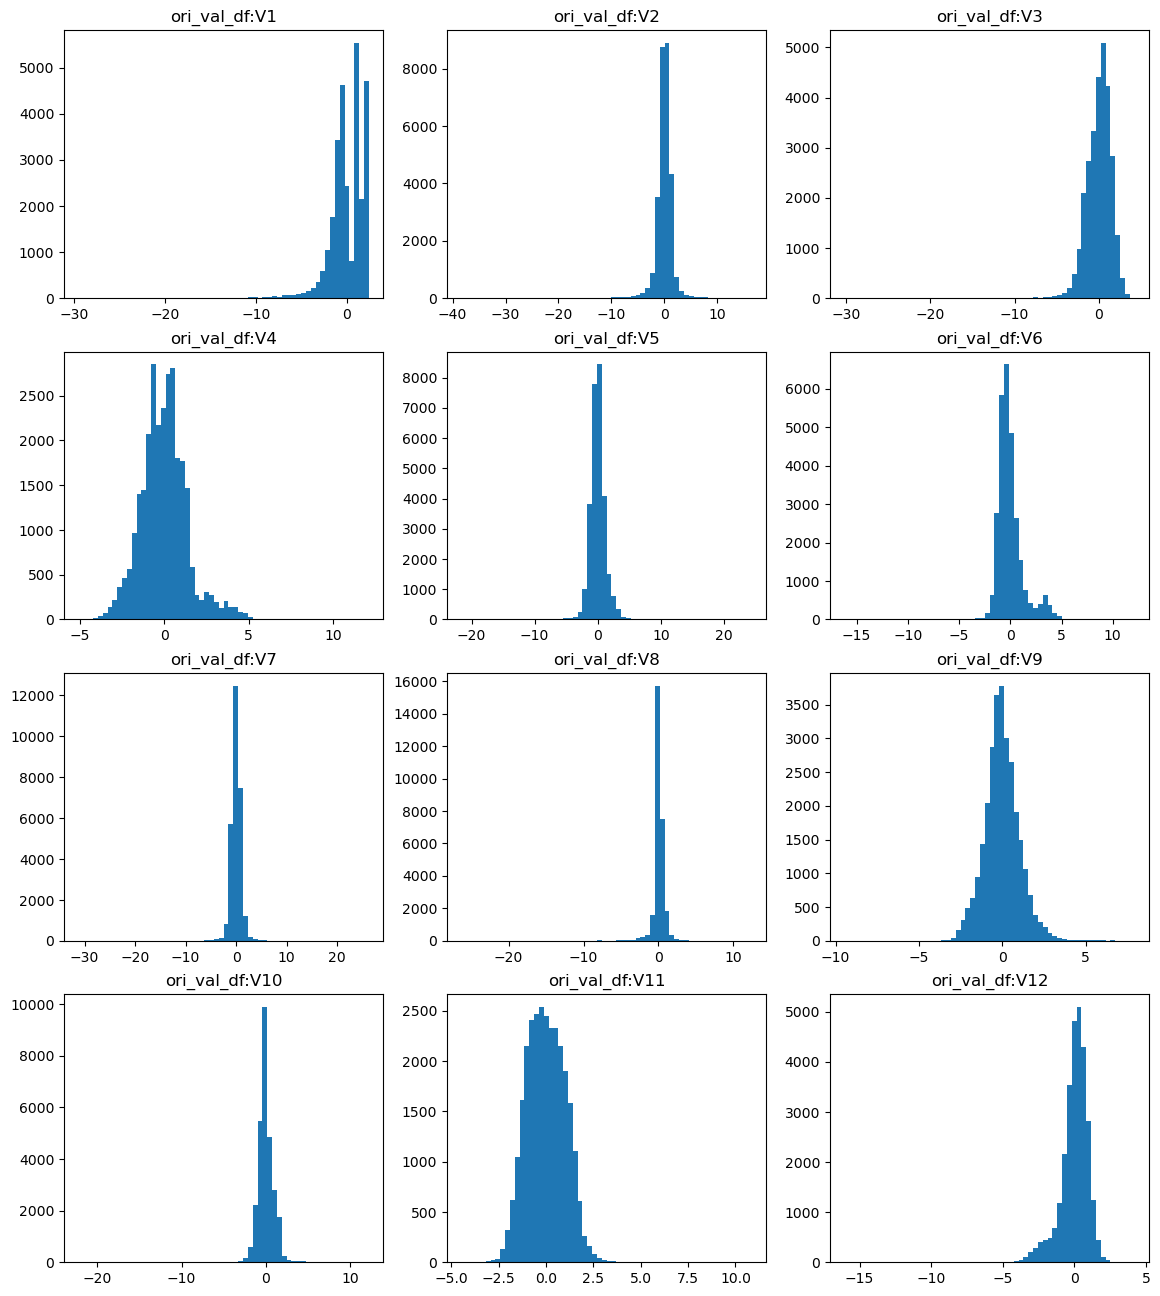

✅ saved: viz_checkpoints\20260112_114353\fig\ori_val_df_raw_hist_top12.png

===== val_class counts =====
0    28432
1       30
Name: count, dtype: int64
✅ saved: logs/datasets_basic.json


In [5]:
# =========================
# [VIZ-CHECK 01] 데이터 로드 직후 검사
# Insert AFTER cell [4] (right after VIZ-CHECK 00)
# =========================
def viz_check_loaded():
    report = {}

    for name in ["train_df", "val_df", "test_df", "ori_val_df"]:
        if name not in globals():
            print(f"⚠️ {name} not found")
            continue
        df = globals()[name]
        if not isinstance(df, pd.DataFrame):
            print(f"⚠️ {name} is not DataFrame")
            continue

        info = {
            "name": name,
            "shape": list(df.shape),
            "null_total": int(df.isna().sum().sum()),
            "dup_rows": int(df.duplicated().sum()),
            "columns": list(df.columns),
        }
        report[name] = info

        print(f"\n===== {name} =====")
        print("shape:", df.shape, "null_total:", info["null_total"], "dup_rows:", info["dup_rows"])
        print(df.head(3))

        desc = df.describe(include="all").transpose()
        _save_csv(desc, f"tables/{name}_describe.csv", index=True)

        # raw 분포 일부 저장(상위 12개 피처)
        feat = _feature_cols(df)
        if feat:
            cols = feat[:12]
            fig = None
            rows = math.ceil(len(cols)/3)
            fig, axes = plt.subplots(rows, 3, figsize=(14, 4*rows))
            axes = np.array(axes).reshape(-1)
            for i,c in enumerate(cols):
                axes[i].hist(df[c].values, bins=60)
                axes[i].set_title(f"{name}:{c}")
            for j in range(i+1, len(axes)):
                axes[j].axis("off")
            p = _save_fig(fig, f"fig/{name}_raw_hist_top12.png")
            plt.show(); plt.close(fig)
            print("✅ saved:", p)

    # val_class 존재 확인(원본 코드에서 val_class 별도)
    if "val_class" in globals():
        y = np.asarray(val_class).reshape(-1)
        vc = pd.Series(y).value_counts().sort_index()
        print("\n===== val_class counts =====")
        print(vc)
        _save_csv(vc.reset_index().rename(columns={"index":"Class",0:"count"}), "tables/val_class_counts.csv", index=False)

    _save_json(report, "logs/datasets_basic.json")
    print("✅ saved: logs/datasets_basic.json")

viz_check_loaded()


In [6]:
# IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
def get_pred_label(model_pred):    
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

# IsolationForest 예측만 하는 함수
def iso_for_model_prediction(the_contamination, trtrtr):
    # train dataset으로 isolationforest 모델 학습
    model_only_train = IsolationForest(n_estimators=1000, contamination=the_contamination, verbose=0)
    model_only_train.fit(trtrtr)
    
    # train dataset의 isolationforest 모델로 예측
    train_pred = model_only_train.predict(trtrtr)
    train_pred = get_pred_label(train_pred)
    
    return train_pred

# Pacmac + IsolationForest 예측과 비교할 수 있는 함수
def pac_iso_for_model_comparing(the_contamination, trtrtr, low_dim, compare_class):
    # train dataset으로 isolationforest 모델 학습
    dlatl_embedding = pacmap.PaCMAP(n_components=low_dim, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = True)
    pac_mac_train = dlatl_embedding.fit_transform(np.array(trtrtr), init="pca")
    
    model_train_compare = IsolationForest(n_estimators=1000, contamination=the_contamination, verbose=0)
    model_train_compare.fit(pac_mac_train)
    
    # train dataset의 isolationforest 모델로 예측
    train_pred = model_train_compare.predict(pac_mac_train)
    train_pred = get_pred_label(train_pred)
    
    # train dataset의 예측치와 compare data의 수치 비교
    train_score = f1_score(compare_class, train_pred, average='macro')

    print(f'Compared Macro F1 Score : [{train_score}]')
    print(classification_report(compare_class, train_score))

# IQR Method에서 경계값을 나타낸 함수
def iqr_outlier(ddff):
    q1 = ddff.quantile(0.25)
    q3 = ddff.quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)

    return pd.concat([lower_bound, upper_bound], axis= 1).T

train_df: finite_ratio=1.000000, null_total=0
val_df: finite_ratio=1.000000, null_total=0
test_df: finite_ratio=1.000000, null_total=0

[Shift Top10] train vs val (PSI)
   feature       psi   ks_stat  ks_pvalue  wasserstein
25     V26  0.000957  0.005031   0.609862     0.003976
8       V9  0.000941  0.009453   0.033953     0.010474
24     V25  0.000877  0.006048   0.374036     0.006017
13     V14  0.000863  0.010257   0.016499     0.011839
18     V19  0.000855  0.005368   0.526122     0.007494
4       V5  0.000604  0.005713   0.445450     0.016953
2       V3  0.000579  0.008100   0.100231     0.018289
20     V21  0.000566  0.007389   0.165584     0.007073
7       V8  0.000468  0.003134   0.978215     0.014555
16     V17  0.000466  0.008033   0.105276     0.008713

[Shift Top10] train vs test (PSI)
   feature       psi   ks_stat  ks_pvalue  wasserstein
7       V8  0.000224  0.004540   0.146777     0.008537
2       V3  0.000219  0.004763   0.112927     0.017969
23     V24  0.000201  0.00

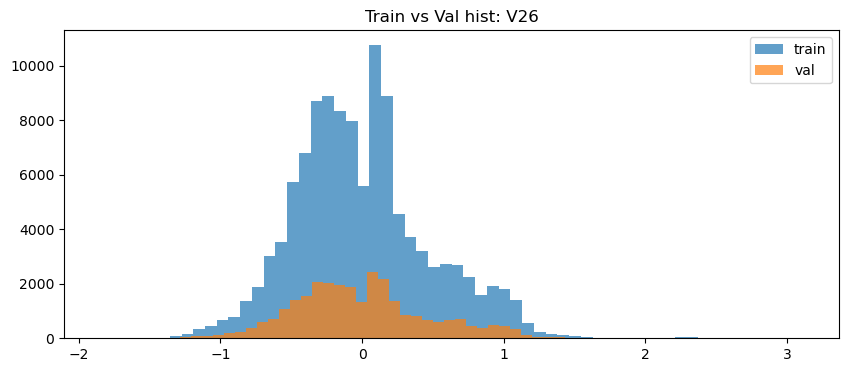

✅ saved: viz_checkpoints\20260112_114353\fig\hist_train_vs_val_V26.png


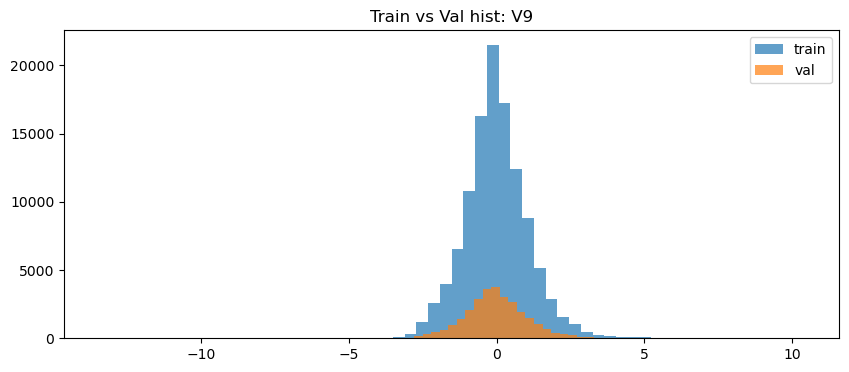

✅ saved: viz_checkpoints\20260112_114353\fig\hist_train_vs_val_V9.png


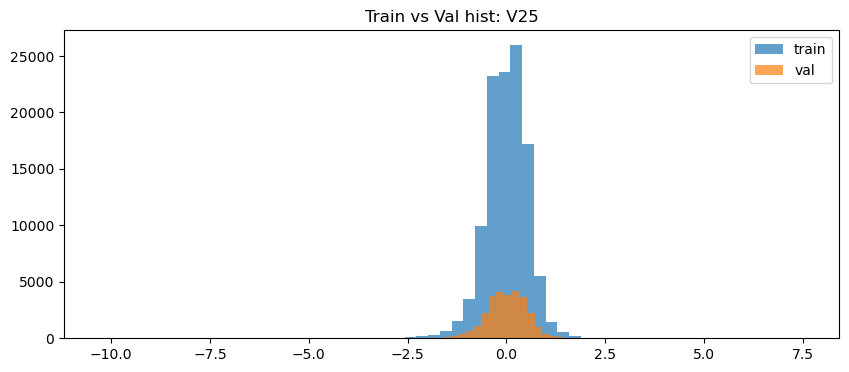

✅ saved: viz_checkpoints\20260112_114353\fig\hist_train_vs_val_V25.png


In [7]:
# =========================
# [VIZ-CHECK 02] 분포 쉬프트/건전성 검사
# Insert AFTER cell [5]
# =========================
def psi_1d(a, b, bins=10, eps=1e-6):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a)==0 or len(b)==0:
        return np.nan
    qs = np.quantile(a, np.linspace(0,1,bins+1))
    qs = np.unique(qs)
    if len(qs) < 3:
        return np.nan
    ha, _ = np.histogram(a, bins=qs)
    hb, _ = np.histogram(b, bins=qs)
    pa = ha / (ha.sum()+eps)
    pb = hb / (hb.sum()+eps)
    pa = np.clip(pa, eps, None)
    pb = np.clip(pb, eps, None)
    return float(np.sum((pa-pb)*np.log(pa/pb)))

def shift_table(train_df, other_df, other_name):
    feat = _feature_cols(train_df)
    rows = []
    for c in feat:
        a = train_df[c].values
        b = other_df[c].values
        row = {"feature": c, "psi": psi_1d(a,b,bins=10)}
        if _HAS_SCIPY:
            try:
                row["ks_stat"] = float(ks_2samp(a, b, nan_policy="omit").statistic)
                row["ks_pvalue"] = float(ks_2samp(a, b, nan_policy="omit").pvalue)
            except Exception:
                row["ks_stat"] = np.nan
                row["ks_pvalue"] = np.nan
            try:
                row["wasserstein"] = float(wasserstein_distance(a[np.isfinite(a)], b[np.isfinite(b)]))
            except Exception:
                row["wasserstein"] = np.nan
        rows.append(row)
    out = pd.DataFrame(rows).sort_values("psi", ascending=False)
    _save_csv(out, f"tables/shift_train_vs_{other_name}.csv", index=False)
    return out

def viz_shift_checks():
    if "train_df" not in globals() or "val_df" not in globals() or "test_df" not in globals():
        print("⚠️ train_df/val_df/test_df missing")
        return

    # 결측/무한대 검사
    for name in ["train_df","val_df","test_df"]:
        df = globals()[name]
        finite_ratio = float(np.isfinite(df.values).mean())
        print(f"{name}: finite_ratio={finite_ratio:.6f}, null_total={df.isna().sum().sum()}")
    _save_json({
        "train_finite_ratio": float(np.isfinite(train_df.values).mean()),
        "val_finite_ratio": float(np.isfinite(val_df.values).mean()),
        "test_finite_ratio": float(np.isfinite(test_df.values).mean()),
    }, "logs/finite_ratios.json")

    tv = shift_table(train_df, val_df, "val")
    tt = shift_table(train_df, test_df, "test")
    print("\n[Shift Top10] train vs val (PSI)")
    print(tv.head(10))
    print("\n[Shift Top10] train vs test (PSI)")
    print(tt.head(10))

    # PSI 상위 feature 히스토그램 3개 저장
    top_feats = tv["feature"].head(3).tolist()
    for c in top_feats:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.hist(train_df[c].values, bins=60, alpha=0.7, label="train")
        ax.hist(val_df[c].values, bins=60, alpha=0.7, label="val")
        ax.set_title(f"Train vs Val hist: {c}")
        ax.legend()
        p = _save_fig(fig, f"fig/hist_train_vs_val_{c}.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

viz_shift_checks()


Validation dataset의 통계정보를 이용한 1차로 변수 선택합니다. 테스트 데이터 중 랜덤 샘플된 것이므로 Validation dataset의 통계정보로 충분히 정보를 얻을 수 있습니다.아래의 기준은 outlier의 중위값이 IQR method의 범위 내에 있는지 확인합니다. 저는 outlier의 중위값이 적어도 IQR method의 범위 밖에 있어야 outlier 판단하기 쉽다고 생각하였습니다.

In [8]:
## 기본적인 변수 선택(1)
def first_variation_selection(dfdfdf):
    # Validation dataset의 outlier들의 중앙값이 Validation dataset의 IQR Method에서 경계값 사이에 있으면 이상치를 판단하지 못하는 변수라고 정했다.
    # class 열도 있으므로 1개 제외
    how_many_var = (len(dfdfdf.columns) - 1)
    new_var = []

    for what_val in range(how_many_var):
        if (iqr_outlier(dfdfdf).iloc[0,what_val] < dfdfdf.iloc[np.where(dfdfdf['Class'] == 1)].quantile(0.5)[what_val] < iqr_outlier(dfdfdf).iloc[1,what_val]):
            continue
        else:
            new_var.append(what_val)

    return new_var

superior_var1 = first_variation_selection(ori_val_df)
print(superior_var1)

[1, 2, 3, 6, 8, 9, 10, 11, 13, 15, 16, 17]


✅ superior_var1 n_features=12
    idx  col
0     1   V2
1     2   V3
2     3   V4
3     6   V7
4     8   V9
5     9  V10
6    10  V11
7    11  V12
8    13  V14
9    15  V16
10   16  V17
11   17  V18


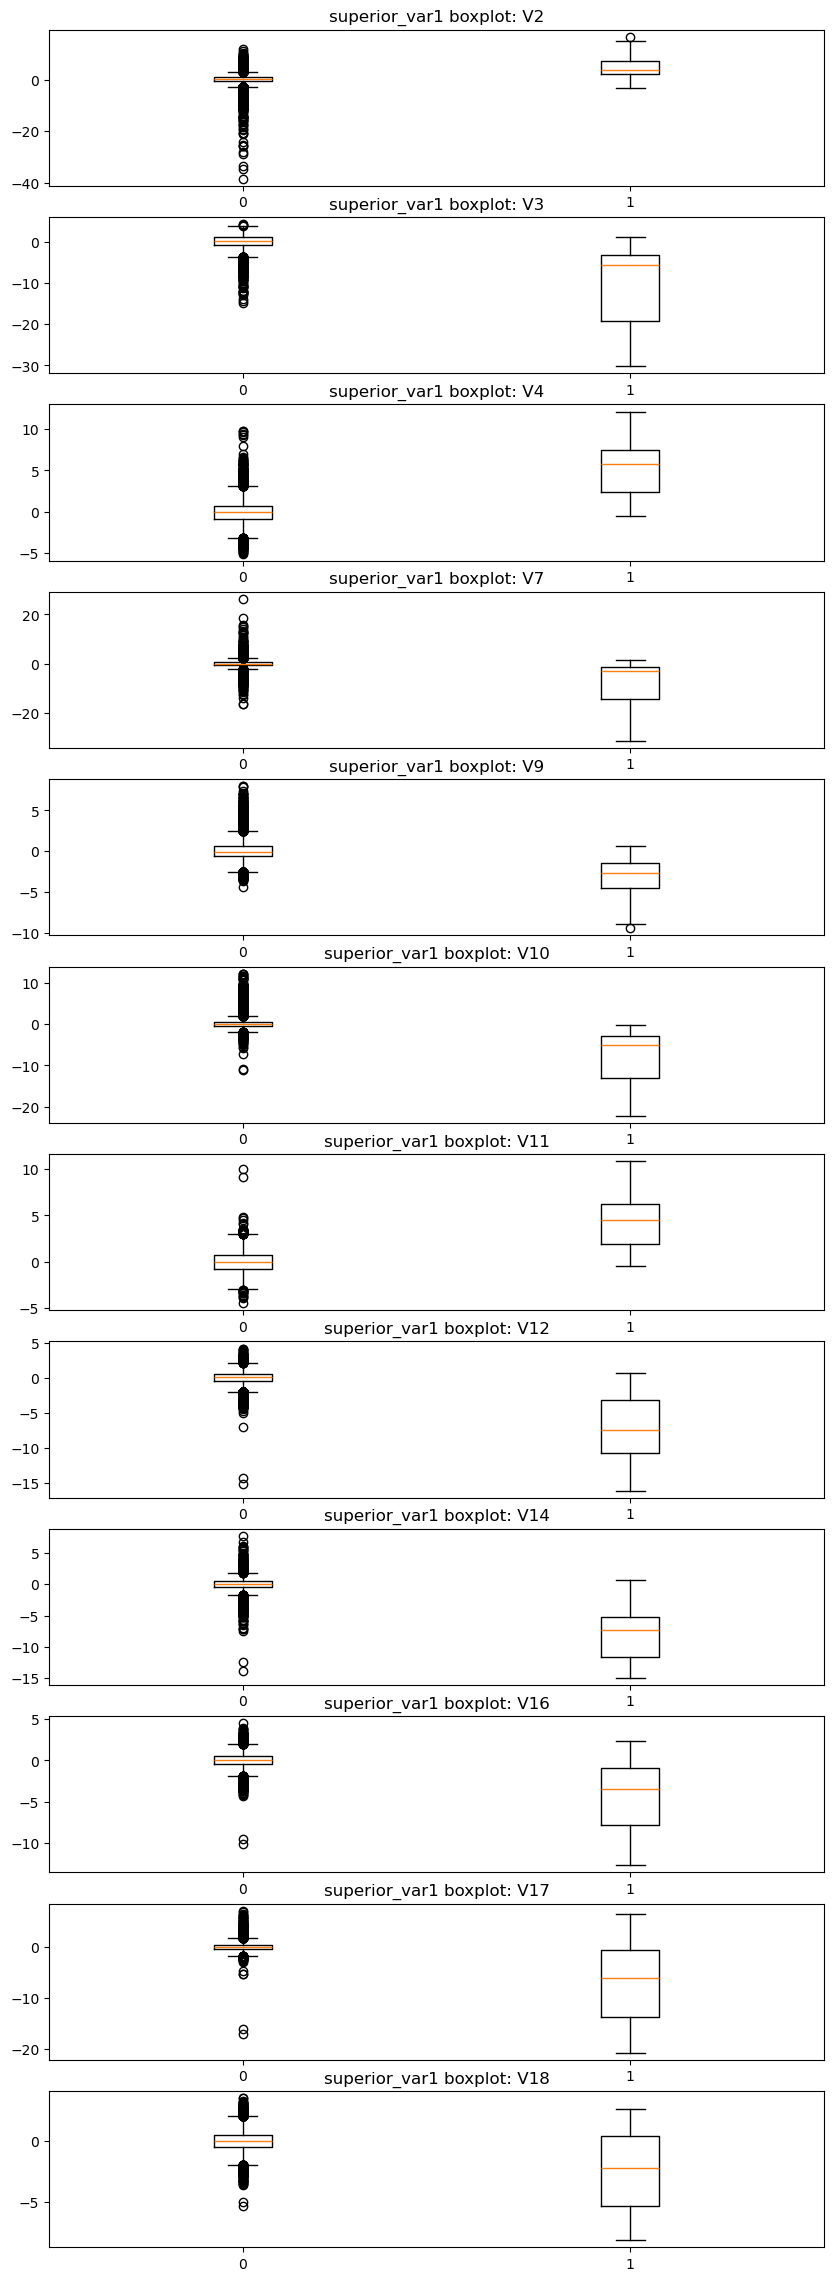

✅ saved: viz_checkpoints\20260112_114353\fig\superior_var1_boxplots_top12.png
✅ saved: C:\Users\xrtwin\Desktop\신용카드 사기 거래 탐지 AI 경진대회 월간 데이콘\open\viz_checkpoints\20260112_114353\tables\superior_var1_class_stats.csv


In [9]:
# =========================
# [VIZ-FEATSEL 01] superior_var1 검증
# Insert AFTER cell [7]
# =========================
def viz_feat_selection(var_idx, tag):
    assert "ori_val_df" in globals(), "ori_val_df not found"
    df = ori_val_df.copy()
    feat_cols = list(df.columns[:-1])  # 마지막은 Class
    y = df["Class"].values

    # idx -> colname 매핑
    idx = list(map(int, var_idx))
    cols = [feat_cols[i] for i in idx if 0 <= i < len(feat_cols)]
    mapping = pd.DataFrame({"idx": idx[:len(cols)], "col": cols})
    _save_csv(mapping, f"tables/{tag}_feature_mapping.csv", index=False)

    print(f"✅ {tag} n_features={len(cols)}")
    print(mapping.head(20))

    # 상위 12개만 박스플롯 (너무 많으면 그림이 커짐)
    cols_plot = cols[:12]
    if cols_plot:
        fig, axes = plt.subplots(len(cols_plot), 1, figsize=(10, 2.4*len(cols_plot)))
        if len(cols_plot) == 1:
            axes = [axes]
        for ax, c in zip(axes, cols_plot):
            # class별 분포
            ax.boxplot([df.loc[df["Class"]==0, c].values, df.loc[df["Class"]==1, c].values], labels=["0","1"])
            ax.set_title(f"{tag} boxplot: {c}")
        p = _save_fig(fig, f"fig/{tag}_boxplots_top12.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

    # class별 평균차/표준편차 저장
    rows = []
    for c in cols:
        a0 = df.loc[df["Class"]==0, c].values
        a1 = df.loc[df["Class"]==1, c].values
        rows.append({
            "feature": c,
            "mean_0": float(np.mean(a0)), "std_0": float(np.std(a0)),
            "mean_1": float(np.mean(a1)), "std_1": float(np.std(a1)),
            "delta_mean": float(np.mean(a1) - np.mean(a0)),
        })
    stat = pd.DataFrame(rows).sort_values("delta_mean", ascending=False)
    _save_csv(stat, f"tables/{tag}_class_stats.csv", index=False)
    print("✅ saved:", (VIZ_ROOT/f"tables/{tag}_class_stats.csv").resolve())

viz_feat_selection(superior_var1, "superior_var1")


이번엔 2차 변수 선택입니다. 두 가지 변수 방법을 사용하여 결과물을 합집합화 하였습니다. 첫번째는 Wilcoxon rank-sum test를 이용해 Validation dataset의 outlier들의 중앙값과 Validation dataset의 inlier들의 중앙값의 차이를 검정해보고 p-value가 가장 낮은 5개 변수를 뽑았습니다. 두번째는 FRUFS의 LGBMRegressor을 이용하여 변수 중요도를 판단하였고 중요도가 가장 높은 5개 변수를 뽑았습니다.

In [10]:
## 기본적인 변수 선택(2)
# 2차 변수 선택
def second_variation_selection(dfdfdf, trtrtr, nnn_var):
    ranksum_pval = []
    for what_val in nnn_var:
        ranksum_pval.append(ranksums(dfdfdf.iloc[np.where(dfdfdf['Class'] == 1)].iloc[:,what_val], dfdfdf.iloc[np.where(dfdfdf['Class'] == 0)].iloc[:,what_val]).pvalue)

    Wilcoxon_rank_sum_pval_var = list(pd.DataFrame({'pval':ranksum_pval, 'col':dfdfdf.columns[nnn_var]}).sort_values(by=['pval']).iloc[range(5),1])

    print(Wilcoxon_rank_sum_pval_var)

    # FRUFS를 이용하여 변수 선택
    # core가 많으면 n_jobs 조정을 하면 됨.
    model_frufs = FRUFS(model_r=LGBMRegressor(random_state=28), k=5, n_jobs=-1, verbose=1, random_state=28)
    df_train_pruned = model_frufs.fit_transform(trtrtr.iloc[:,nnn_var])
    FRUFS_LGBMRegressor_var = list(df_train_pruned.columns)

    #plt.figure(figsize=(5, 6), dpi=100)
    #model_frufs.feature_importance()
    print(FRUFS_LGBMRegressor_var)

    # 종합
    all_var_in_td = list(trtrtr.columns)
    new_var_set = list(set(Wilcoxon_rank_sum_pval_var + FRUFS_LGBMRegressor_var))
    new_var_list = []

    for nvs in new_var_set:
        new_var_list.append(all_var_in_td.index(nvs))

    new_var_list.sort()
    return new_var_list

superior_var2 = second_variation_selection(ori_val_df, train_df, superior_var1)
print(superior_var2)

['V10', 'V14', 'V11', 'V4', 'V12']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   11.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   11.8s finished


['V10', 'V4', 'V14', 'V17', 'V16']
[3, 9, 10, 11, 13, 15, 16]


✅ superior_var2 n_features=7
   idx  col
0    3   V4
1    9  V10
2   10  V11
3   11  V12
4   13  V14
5   15  V16
6   16  V17


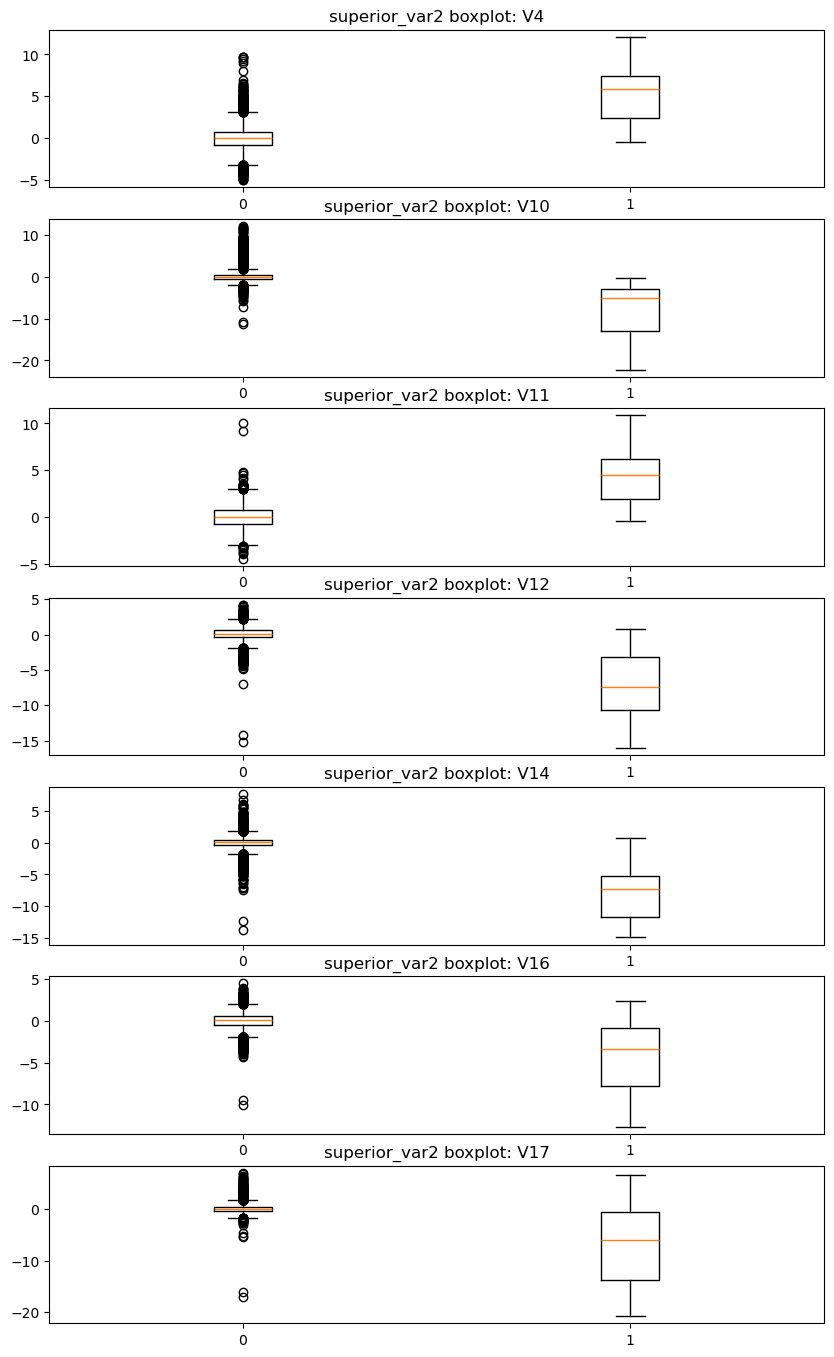

✅ saved: viz_checkpoints\20260112_114353\fig\superior_var2_boxplots_top12.png
✅ saved: C:\Users\xrtwin\Desktop\신용카드 사기 거래 탐지 AI 경진대회 월간 데이콘\open\viz_checkpoints\20260112_114353\tables\superior_var2_class_stats.csv


In [11]:
# =========================
# [VIZ-FEATSEL 02] superior_var2 검증
# Insert AFTER cell [9]
# =========================
viz_feat_selection(superior_var2, "superior_var2")


In [12]:
## 기본적인 변수 선택(3)
# 선택한 변수 제외 나머지 변수 모임
inferior_var2 = [x for x in range(30) if x not in superior_var2]
print(inferior_var2)

[0, 1, 2, 4, 5, 6, 7, 8, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


✅ inferior_var2 n_features=23
    idx  col
0     0   V1
1     1   V2
2     2   V3
3     4   V5
4     5   V6
5     6   V7
6     7   V8
7     8   V9
8    12  V13
9    14  V15
10   17  V18
11   18  V19
12   19  V20
13   20  V21
14   21  V22
15   22  V23
16   23  V24
17   24  V25
18   25  V26
19   26  V27


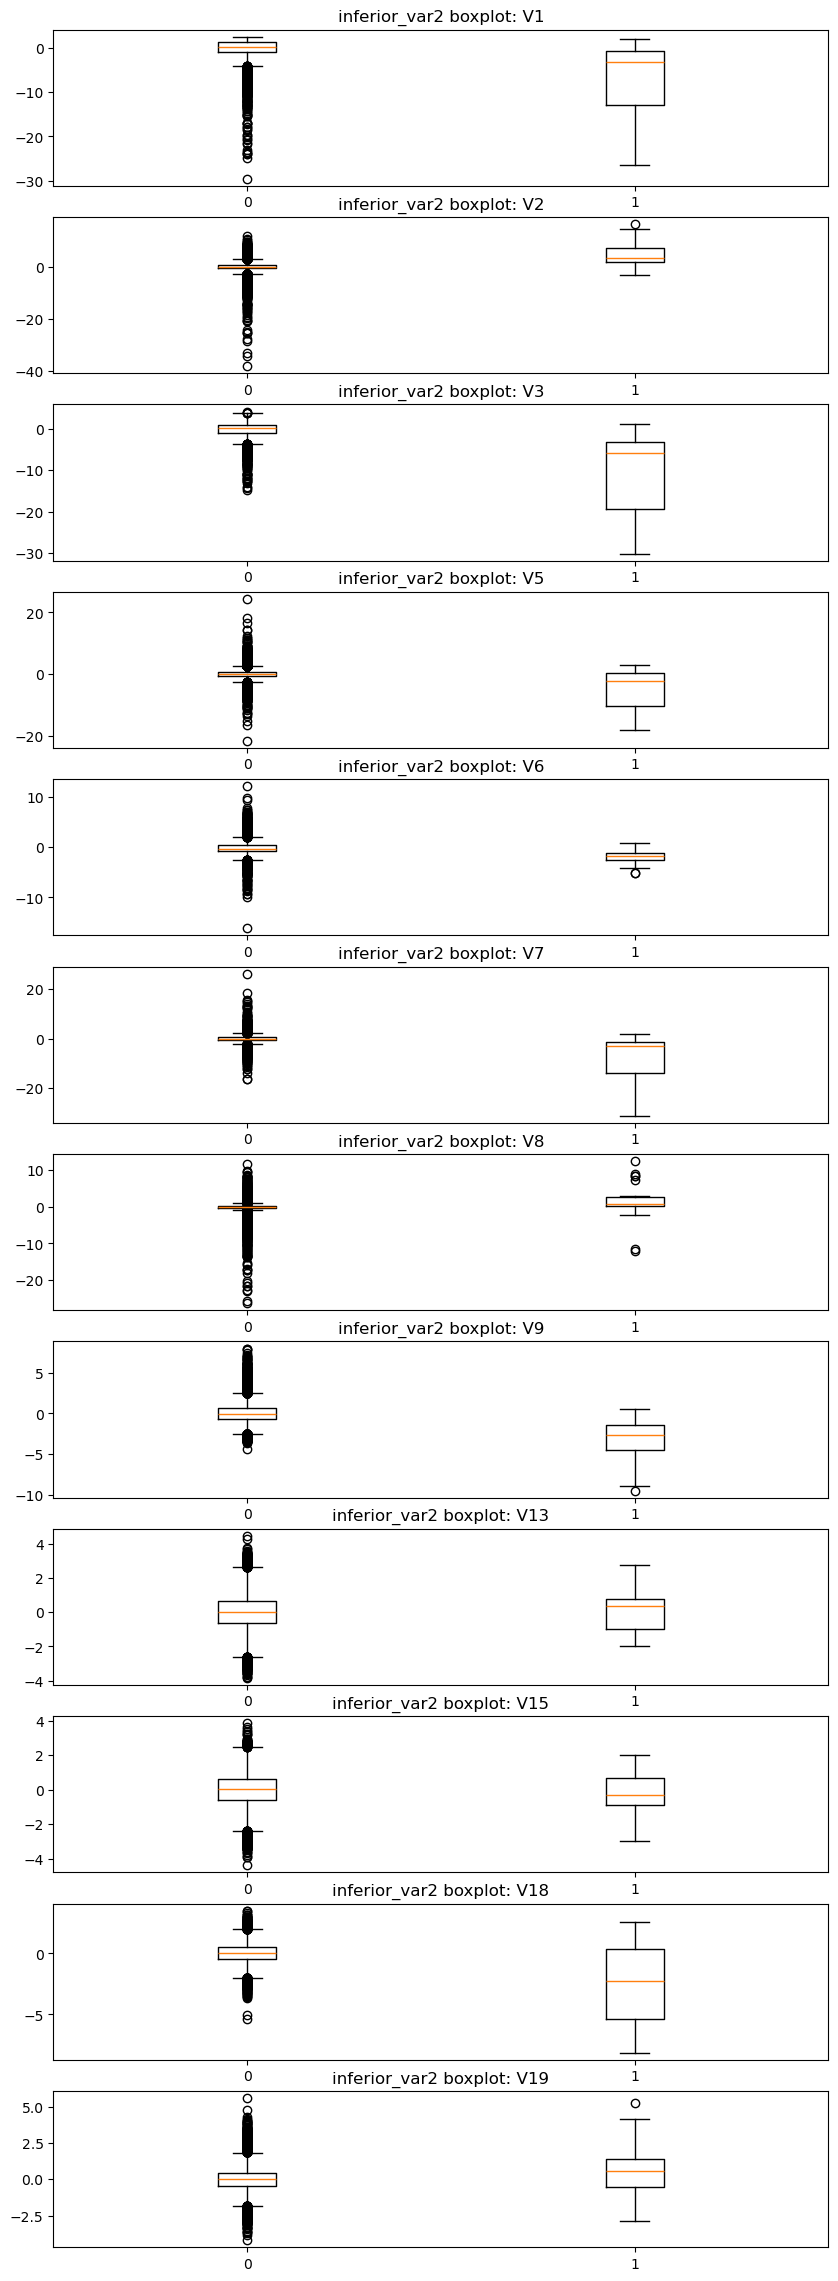

✅ saved: viz_checkpoints\20260112_114353\fig\inferior_var2_boxplots_top12.png
✅ saved: C:\Users\xrtwin\Desktop\신용카드 사기 거래 탐지 AI 경진대회 월간 데이콘\open\viz_checkpoints\20260112_114353\tables\inferior_var2_class_stats.csv


In [13]:
# =========================
# [VIZ-FEATSEL 03] inferior_var2(제외 변수) 검증
# Insert AFTER cell [10]
# =========================
viz_feat_selection(inferior_var2, "inferior_var2")


Baseline에 보시면 아시겠지만 validation set의 사기 거래 비율을 탐색하였는데 저는 이보다 조금 높은 수치를 사용하였습니다.

In [14]:
## validation set의 사기 거래 비율 탐색
ori_val_normal, ori_val_fraud = ori_val_df['Class'].value_counts()
ori_val_contamination = ori_val_fraud / ori_val_normal
print(f'Validation contamination:[{ori_val_contamination}]')
# 이대로 하지 않고 조정을 함

Validation contamination:[0.0010551491277433877]


{'val_n': 28462, 'val_counts': {'0': 28432, '1': 30}, 'val_fraud_rate': 0.0010540369615627855, 'ori_val_contamination': 0.0010551491277433877}


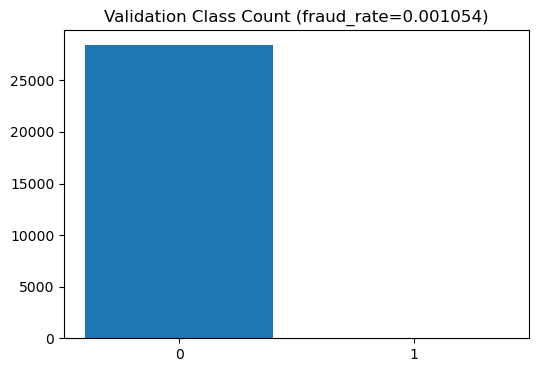

✅ saved: viz_checkpoints\20260112_114353\fig\val_class_bar.png


In [15]:
# =========================
# [VIZ-IMBALANCE] contamination/불균형 검증
# Insert AFTER cell [12]
# =========================
def viz_imbalance():
    y = ori_val_df["Class"].values
    counts = pd.Series(y).value_counts().sort_index()
    n = len(y)
    fraud_rate = float(np.mean(y==1))

    info = {
        "val_n": int(n),
        "val_counts": {str(k): int(v) for k,v in counts.to_dict().items()},
        "val_fraud_rate": fraud_rate,
        "ori_val_contamination": float(ori_val_contamination) if "ori_val_contamination" in globals() else None
    }
    print(info)
    _save_json(info, "logs/imbalance.json")
    _save_csv(counts.reset_index().rename(columns={"index":"Class",0:"count"}), "tables/imbalance_val_counts.csv", index=False)

    # bar plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(f"Validation Class Count (fraud_rate={fraud_rate:.6f})")
    p = _save_fig(fig, "fig/val_class_bar.png")
    plt.show(); plt.close(fig)
    print("✅ saved:", p)

    # 기대 outlier 수 (train/test)
    if "train_df" in globals():
        info["train_n"] = int(len(train_df))
        info["train_expected_fraud_by_val_rate"] = float(len(train_df)*fraud_rate)
    if "test_df" in globals():
        info["test_n"] = int(len(test_df))
        info["test_expected_fraud_by_val_rate"] = float(len(test_df)*fraud_rate)
    _save_json(info, "logs/imbalance_with_expectations.json")

viz_imbalance()


본격적으로 pacmap과 isolation forest를 이용하여 예측하고자 합니다. pacmap은 차원축소를 하는 과정에 있어 랜덤하게 이동합니다. isolation forest도 랜덤하게 변수를 선택하기 때문에 결과가 불분명합니다. 따라서 저는 hhmm번 진행하고 voting을 통해 결과를 도출하였습니다.

In [16]:
## pacmap과 isolation forest 1차 이용(1)
# pacmap과 isolation forest를 이용한 1차 예측
hhmm = 3
what_val = superior_var2
for num in range(hhmm):
    embedding_1 = pacmap.PaCMAP(n_components=len(what_val), n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = True)
    pacmac_train_1 = embedding_1.fit_transform(np.array(train_df.iloc[:,what_val]), init="pca")
    pacmac_val_1 = embedding_1.transform(np.array(val_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))
    pacmac_test_1 = embedding_1.transform(np.array(test_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))

    pac_model_1 = IsolationForest(n_estimators=1000, contamination=0.00121, verbose=0)
    pac_model_1.fit(pacmac_train_1[:,[1,2,3]]) 

    if num == 0:
        train_pred_set_1 = pac_model_1.predict(pacmac_train_1[:,[1,2,3]]) # model prediction
        train_pred_set_1 = get_pred_label(train_pred_set_1)

        val_pred_set_1 = pac_model_1.predict(pacmac_val_1[:,[1,2,3]]) # model prediction
        val_pred_set_1 = get_pred_label(val_pred_set_1)

        test_pred_set_1 = pac_model_1.predict(pacmac_test_1[:,[1,2,3]]) # model prediction
        test_pred_set_1 = get_pred_label(test_pred_set_1)
    else:
        train_pred_1 = pac_model_1.predict(pacmac_train_1[:,[1,2,3]]) # model prediction
        train_pred_1 = get_pred_label(train_pred_1)
        train_pred_set_1 = train_pred_set_1 + train_pred_1

        val_pred_1 = pac_model_1.predict(pacmac_val_1[:,[1,2,3]]) # model prediction
        val_pred_1 = get_pred_label(val_pred_1)
        val_pred_set_1 = val_pred_set_1 + val_pred_1

        test_pred_1 = pac_model_1.predict(pacmac_test_1[:,[1,2,3]]) # model prediction
        test_pred_1 = get_pred_label(test_pred_1)
        test_pred_set_1 = test_pred_set_1 + test_pred_1

train_pred_set_1 = train_pred_set_1/hhmm
val_pred_set_1 = val_pred_set_1/hhmm
test_pred_set_1 = test_pred_set_1/hhmm

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2402824.500000
Iteration:   20, Loss: 2148092.500000
Iteration:   30, Loss: 2014411.000000
Iteration:   40, Loss: 1910480.500000
Iteration:   50, Loss: 1811082.250000
Iteration:   60, Loss: 1705762.500000
Iteration:   70, Loss: 1587545.000000
Iteration:   80, Loss: 1447400.375000
Iteration:   90, Loss: 1270942.500000
Iteration:  100, Loss: 1005035.750000
Iteration:  110, Loss: 1315226.875000
Iteration:  120, Loss: 1292801.750000
Iteration:  130, Loss: 1283148.250000
Iteration:  140, Loss: 1280056.250000
Iteration:  150, Loss: 1279516.375000
Iteration:  160, Loss: 1279560.625000
Iteration:  170, Loss: 1279685.500

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2402549.500000
Iteration:   20, Loss: 2148098.750000
Iteration:   30, Loss: 2014376.000000
Iteration:   40, Loss: 1910183.250000
Iteration:   50, Loss: 1810902.750000
Iteration:   60, Loss: 1705666.500000
Iteration:   70, Loss: 1587451.625000
Iteration:   80, Loss: 1447244.875000
Iteration:   90, Loss: 1270876.500000
Iteration:  100, Loss: 1004992.625000
Iteration:  110, Loss: 1315172.000000
Iteration:  120, Loss: 1292856.125000
Iteration:  130, Loss: 1283331.625000
Iteration:  140, Loss: 1280205.875000
Iteration:  150, Loss: 1279599.000000
Iteration:  160, Loss: 1279655.125000
Iteration:  170, Loss: 1279761.250

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2402905.750000
Iteration:   20, Loss: 2148095.250000
Iteration:   30, Loss: 2014469.750000
Iteration:   40, Loss: 1910400.250000
Iteration:   50, Loss: 1811076.000000
Iteration:   60, Loss: 1705783.625000
Iteration:   70, Loss: 1587575.500000
Iteration:   80, Loss: 1447435.750000
Iteration:   90, Loss: 1270947.125000
Iteration:  100, Loss: 1004989.750000
Iteration:  110, Loss: 1315229.875000
Iteration:  120, Loss: 1292893.000000
Iteration:  130, Loss: 1283317.750000
Iteration:  140, Loss: 1280205.750000
Iteration:  150, Loss: 1279624.625000
Iteration:  160, Loss: 1279729.750000
Iteration:  170, Loss: 1279810.750

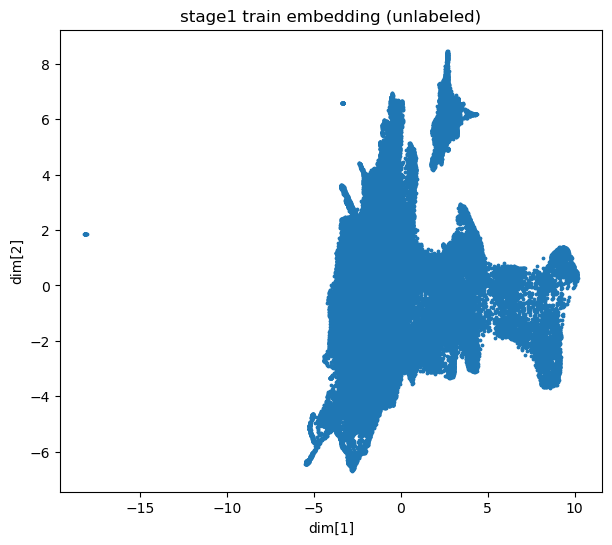

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_train_scatter2d.png


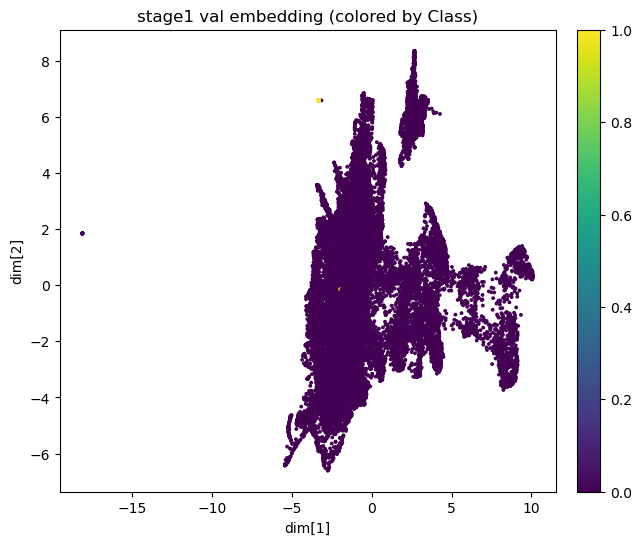

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_val_scatter2d_byClass.png


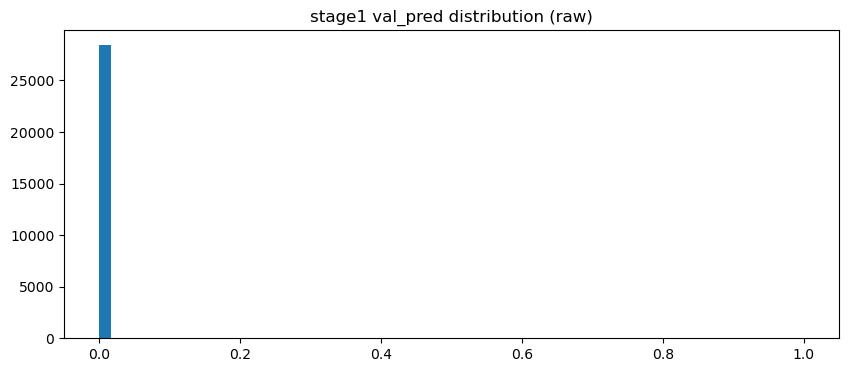

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_val_pred_hist.png

[stage1] confusion_matrix:
 [[28429     3]
 [    6    24]]
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998     28432
           1     0.8889    0.8000    0.8421        30

    accuracy                         0.9997     28462
   macro avg     0.9443    0.8999    0.9210     28462
weighted avg     0.9997    0.9997    0.9997     28462



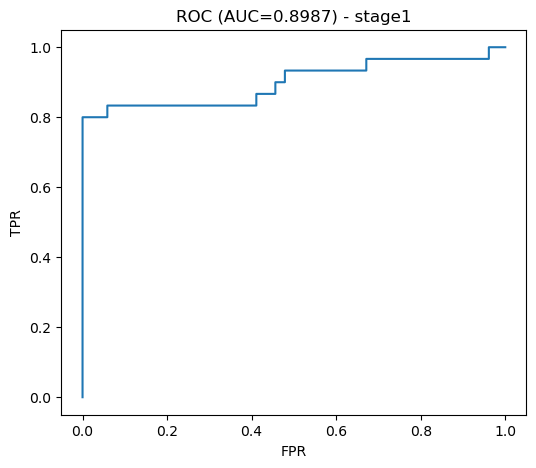

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_roc.png


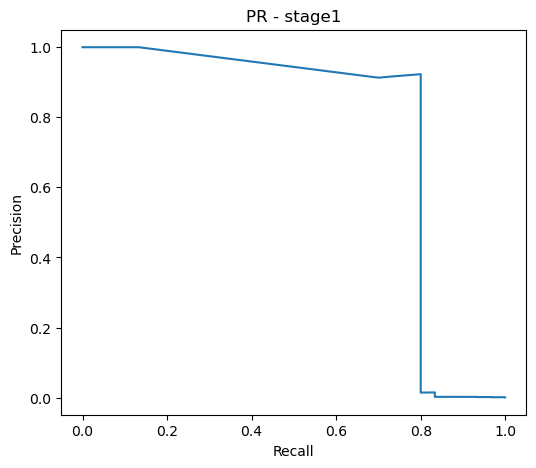

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_pr.png


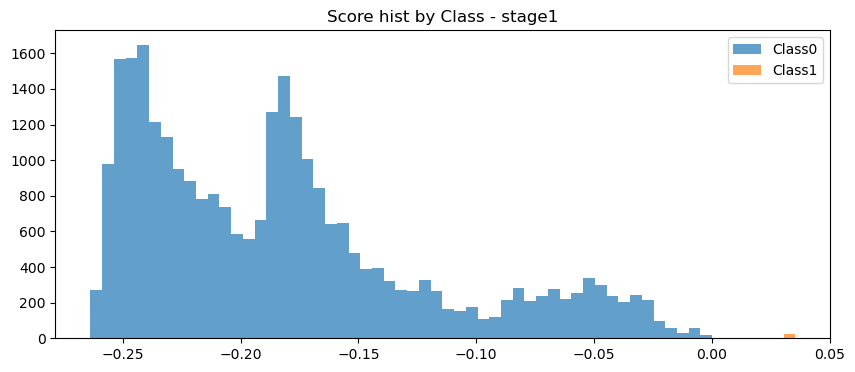

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_score_hist_by_class.png


In [17]:
# =========================
# [VIZ-EMB/PRED-1] stage-1 임베딩/예측 검증
# Insert AFTER cell [14]
# =========================
def viz_stage_embedding_pred(stage_tag, emb_train, emb_val, emb_test, pred_train, pred_val, pred_test, model=None):
    # 1) 임베딩 저장
    _save_npy(np.asarray(emb_train), f"arrays/{stage_tag}_emb_train.npy")
    _save_npy(np.asarray(emb_val),   f"arrays/{stage_tag}_emb_val.npy")
    _save_npy(np.asarray(emb_test),  f"arrays/{stage_tag}_emb_test.npy")

    # 2) 산점도(2D)
    fig = _scatter2d(emb_train, f"{stage_tag} train embedding (unlabeled)")
    p = _save_fig(fig, f"fig/{stage_tag}_train_scatter2d.png")
    plt.show(); plt.close(fig); print("✅ saved:", p)

    y = ori_val_df["Class"].values if "ori_val_df" in globals() and "Class" in ori_val_df.columns else None
    if y is not None and len(y) == len(emb_val):
        fig = _scatter2d(emb_val, f"{stage_tag} val embedding (colored by Class)", color=y)
        p = _save_fig(fig, f"fig/{stage_tag}_val_scatter2d_byClass.png")
        plt.show(); plt.close(fig); print("✅ saved:", p)
    else:
        fig = _scatter2d(emb_val, f"{stage_tag} val embedding (uncolored)")
        p = _save_fig(fig, f"fig/{stage_tag}_val_scatter2d.png")
        plt.show(); plt.close(fig); print("✅ saved:", p)

    # 3) pred 저장/분포
    pred_train = np.asarray(pred_train).reshape(-1)
    pred_val   = np.asarray(pred_val).reshape(-1)
    pred_test  = np.asarray(pred_test).reshape(-1)
    _save_npy(pred_train, f"arrays/{stage_tag}_pred_train.npy")
    _save_npy(pred_val,   f"arrays/{stage_tag}_pred_val.npy")
    _save_npy(pred_test,  f"arrays/{stage_tag}_pred_test.npy")

    fig = _hist(pred_val, f"{stage_tag} val_pred distribution (raw)")
    p = _save_fig(fig, f"fig/{stage_tag}_val_pred_hist.png")
    plt.show(); plt.close(fig); print("✅ saved:", p)

    # 4) val 성능(원본 코드가 round 사용)
    metrics = {"stage": stage_tag}
    if y is not None and len(y) == len(pred_val):
        yhat = np.round(pred_val).astype(int)
        metrics.update({
            "val_pos_rate_round": float(np.mean(yhat==1)),
            "val_f1_macro": float(f1_score(y, yhat, average="macro")),
            "val_precision_1": float(precision_score(y, yhat, zero_division=0)),
            "val_recall_1": float(recall_score(y, yhat, zero_division=0)),
        })
        cm = confusion_matrix(y, yhat)
        print(f"\n[{stage_tag}] confusion_matrix:\n", cm)
        print(classification_report(y, yhat, digits=4, zero_division=0))

        _save_csv(pd.DataFrame(cm, index=["true0","true1"], columns=["pred0","pred1"]), f"tables/{stage_tag}_cm.csv", index=True)
        _save_json(metrics, f"logs/{stage_tag}_metrics.json")

    # 5) (가능하면) anomaly score 기반 AUC/ROC/PR
    if model is not None and hasattr(model, "decision_function") and y is not None and len(y)==len(emb_val):
        try:
            # 원본은 [1,2,3] 축을 사용
            Xv = np.asarray(emb_val)
            if Xv.shape[1] >= 4:
                scores = -model.decision_function(Xv[:, [1,2,3]])
                aucv = roc_auc_score(y, scores)
                metrics["val_auc_score_based"] = float(aucv)

                # ROC curve
                fpr, tpr, _ = roc_curve(y, scores)
                fig, ax = plt.subplots(figsize=(6,5))
                ax.plot(fpr, tpr)
                ax.set_title(f"ROC (AUC={aucv:.4f}) - {stage_tag}")
                ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
                p = _save_fig(fig, f"fig/{stage_tag}_roc.png")
                plt.show(); plt.close(fig); print("✅ saved:", p)

                # PR curve
                prec, rec, _ = precision_recall_curve(y, scores)
                fig, ax = plt.subplots(figsize=(6,5))
                ax.plot(rec, prec)
                ax.set_title(f"PR - {stage_tag}")
                ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
                p = _save_fig(fig, f"fig/{stage_tag}_pr.png")
                plt.show(); plt.close(fig); print("✅ saved:", p)

                # score hist by class
                fig, ax = plt.subplots(figsize=(10,4))
                ax.hist(scores[y==0], bins=60, alpha=0.7, label="Class0")
                ax.hist(scores[y==1], bins=60, alpha=0.7, label="Class1")
                ax.set_title(f"Score hist by Class - {stage_tag}")
                ax.legend()
                p = _save_fig(fig, f"fig/{stage_tag}_score_hist_by_class.png")
                plt.show(); plt.close(fig); print("✅ saved:", p)

                _save_npy(scores, f"arrays/{stage_tag}_val_scores.npy")
                _save_json(metrics, f"logs/{stage_tag}_metrics.json")
            else:
                print(f"⚠️ {stage_tag}: embedding dim < 4 -> score-based auc skip")
        except Exception as e:
            print("⚠️ score-based check failed:", e)

# stage-1 변수명(원본 그대로)
viz_stage_embedding_pred(
    "stage1",
    pacmac_train_1, pacmac_val_1, pacmac_test_1,
    train_pred_set_1, val_pred_set_1, test_pred_set_1,
    model=pac_model_1 if "pac_model_1" in globals() else None
)


In [18]:
## pacmap과 isolation forest 1차 이용(2)
val_score_1 = f1_score(ori_val_df['Class'], np.round(val_pred_set_1), average='macro')

print(f'Validation F1 Score : [{val_score_1}]')
print(classification_report(ori_val_df['Class'], np.round(val_pred_set_1)))
print(confusion_matrix(ori_val_df['Class'], np.round(val_pred_set_1)))

Validation F1 Score : [0.9209734995691701]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.89      0.80      0.84        30

    accuracy                           1.00     28462
   macro avg       0.94      0.90      0.92     28462
weighted avg       1.00      1.00      1.00     28462

[[28429     3]
 [    6    24]]


In [19]:
# =========================
# [VIZ-EVAL-1] stage-1 평가 출력 저장 강화
# Insert AFTER cell [15]
# =========================
y = ori_val_df["Class"].values
yhat = np.round(val_pred_set_1).astype(int)

report = classification_report(y, yhat, digits=4, zero_division=0, output_dict=True)
cm = confusion_matrix(y, yhat)

_save_json(report, "logs/stage1_classification_report.json")
_save_csv(pd.DataFrame(cm, index=["true0","true1"], columns=["pred0","pred1"]), "tables/stage1_cm_from_evalcell.csv", index=True)

print("✅ saved stage1 report/cm")


✅ saved stage1 report/cm


In [20]:
## pacmap과 isolation forest 1차 이용(3)
# 1차 저장
chujung_train_1 = pd.DataFrame({'Class':np.round(train_pred_set_1)})
chujung_val_1 = pd.DataFrame({'Class':np.round(val_pred_set_1)})
chujung_test_1 = pd.DataFrame({'Class':np.round(test_pred_set_1)})

result_train_1 = pd.concat([train_df,chujung_train_1], axis=1)
result_val_1 = pd.concat([val_df,chujung_val_1], axis=1)
result_test_1 = pd.concat([test_df,chujung_test_1], axis=1)

result_train_1.to_csv('result_train_1.csv', index=False)
result_val_1.to_csv('result_val_1.csv', index=False)
result_test_1.to_csv('result_test_1.csv', index=False)

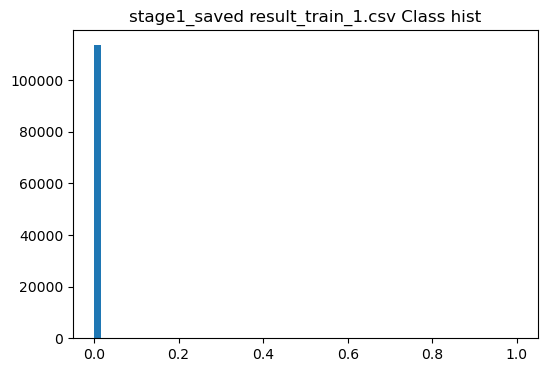

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_saved_result_train_1.csv_hist.png
✅ result_train_1.csv md5: a742448c6acc1ad969356fe30bdac640 shape: (113842, 31)


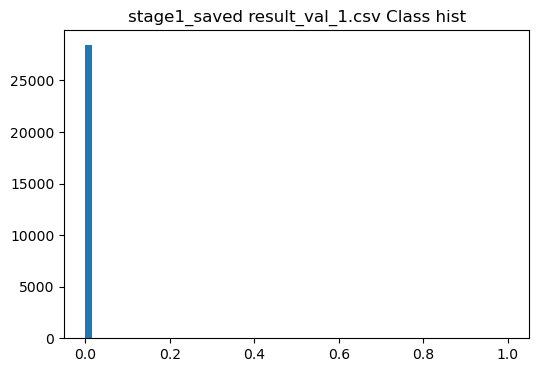

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_saved_result_val_1.csv_hist.png
✅ result_val_1.csv md5: 1b4b9cfd4f515aaa970559d2bb1c2d30 shape: (28462, 31)


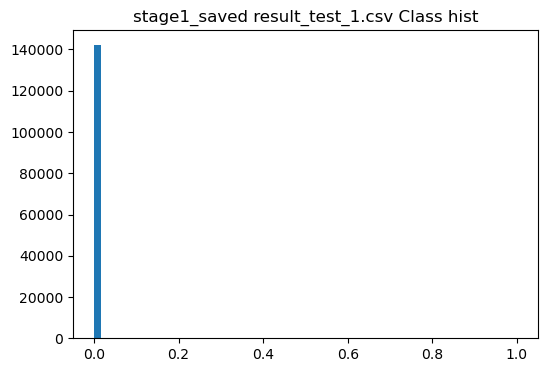

✅ saved: viz_checkpoints\20260112_114353\fig\stage1_saved_result_test_1.csv_hist.png
✅ result_test_1.csv md5: 474e814bcf2fd8d8e037d08222df95a3 shape: (142503, 31)
✅ saved: logs/stage1_saved_file_meta.json


In [21]:
# =========================
# [VIZ-FILE-1] result_*_1.csv 무결성 검사/백업
# Insert AFTER cell [16]
# =========================
def file_check_and_backup(paths, tag):
    meta = {}
    for p in paths:
        if not os.path.exists(p):
            print("⚠️ missing:", p)
            meta[p] = {"exists": False}
            continue
        md5 = _md5_file(p)
        df = pd.read_csv(p)
        meta[p] = {
            "exists": True,
            "md5": md5,
            "shape": list(df.shape),
            "columns": list(df.columns),
            "class_counts": df["Class"].value_counts(dropna=False).to_dict() if "Class" in df.columns else None
        }
        # 백업 복사
        shutil.copy(p, VIZ_ROOT/"backup"/f"{tag}_{os.path.basename(p)}")
        # 분포 그림
        if "Class" in df.columns:
            fig, ax = plt.subplots(figsize=(6,4))
            ax.hist(df["Class"].values, bins=60)
            ax.set_title(f"{tag} {os.path.basename(p)} Class hist")
            sp = _save_fig(fig, f"fig/{tag}_{os.path.basename(p)}_hist.png")
            plt.show(); plt.close(fig)
            print("✅ saved:", sp)

        print("✅", p, "md5:", md5, "shape:", df.shape)

    _save_json(meta, f"logs/{tag}_file_meta.json")
    print("✅ saved:", f"logs/{tag}_file_meta.json")

file_check_and_backup(
    ["result_train_1.csv", "result_val_1.csv", "result_test_1.csv"],
    "stage1_saved"
)


In [22]:
## pacmap과 isolation forest 1차 이용(4)
# 1차 불러오기
train_pred_set_1 = np.array(pd.read_csv('result_train_1.csv')['Class'])
val_pred_set_1 = np.array(pd.read_csv('result_val_1.csv')['Class'])
test_pred_set_1 = np.array(pd.read_csv('result_test_1.csv')['Class'])

In [23]:
# =========================
# [VIZ-RELOAD-1] stage1 재로딩 값 확인(선택)
# Insert AFTER cell [17]
# =========================
def reload_consistency_check(tag, pred_mem, csv_path):
    if not os.path.exists(csv_path):
        print("⚠️ missing:", csv_path); return
    df = pd.read_csv(csv_path)
    arr = df["Class"].values
    pred_mem = np.asarray(pred_mem).reshape(-1)
    same = (len(arr)==len(pred_mem)) and np.allclose(arr, pred_mem)
    print(f"[{tag}] {csv_path} equal_to_memory:", same)
    _save_json({"file": csv_path, "equal_to_memory": bool(same)}, f"logs/{tag}_reload_consistency.json")

# 셀[17] 실행 후 train_pred_set_1 등이 csv로부터 로드된 상태임
reload_consistency_check("stage1_train", train_pred_set_1, "result_train_1.csv")
reload_consistency_check("stage1_val",   val_pred_set_1,   "result_val_1.csv")
reload_consistency_check("stage1_test",  test_pred_set_1,  "result_test_1.csv")


[stage1_train] result_train_1.csv equal_to_memory: True
[stage1_val] result_val_1.csv equal_to_memory: True
[stage1_test] result_test_1.csv equal_to_memory: True


저는 이에 더해 변수를 좀 더 추가하면서 val score를 높일 수 있을까 생각하였습니다. 그래서 저는 설령 outlier들이 inlier안에 숨어있을지라도 inlier들이 모여있으면 isolation forest가 판단하는데 있어서 도움이 된다고 들었습니다. 이에 따라 저는 outlier들이 inlier안에 들어있지만 최대한 outlier들의 분산이 적으면서 최대한 inlier들의 분산을 넓은 변수를 찾고자 하였습니다. (i.e. (inlier들의 분산/outlier들의 분산)이 높은 것들). 역시 validation set의 통계정보를 이용하였습니다. 그 다음, outlier의 중앙값을 기준으로 inlier들을 나누어서, 각 inlier들의 중앙값이 outlier의 중앙값과 차이가 큰지(wilcoxon rank sum test), 각 inlier들의 분산이 작은지(해당 분산이 작으면 inlier와 구별할 수 있다고 생각하였습니다.)를 보았습니다. 변수를 최대한 적게 선택하고자 이번엔 해당 방법들에서 나온 변수들의 교집합을 선택하였습니다.

In [24]:
## pacmap과 isolation forest 2차 이용
inside_in_inlier= []

for what_val in range(30):
    if ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)].max()[what_val] <  ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)].max()[what_val]:
        if ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)].min()[what_val] >  ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)].min()[what_val]:
            inside_in_inlier.append(what_val)

print(inside_in_inlier)

var_chai = []
for what_val in inside_in_inlier:
    print(what_val , ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],what_val].var()/ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],what_val].var())
    var_chai.append(ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],what_val].var()/ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],what_val].var())

old_born_idx = np.argsort((-1)*np.array(var_chai))[:5]
old_born_idx = np.array(inside_in_inlier)[list(old_born_idx)]
old_born_idx = list(old_born_idx)
print(old_born_idx)

left_side_l = []
right_side_l = []
for jjkk in inside_in_inlier:
    the_one_the_one = ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],jjkk]
    median_the_one = the_one_the_one.median()
    the_zero_the_zero = ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],jjkk]
    left_zero_val_df = the_zero_the_zero.iloc[np.where(the_zero_the_zero < median_the_one)[0]]
    right_zero_val_df = the_zero_the_zero.iloc[np.where(the_zero_the_zero > median_the_one)[0]]
    left_ppp = (ranksums(left_zero_val_df, the_one_the_one).pvalue)
    right_ppp = (ranksums(right_zero_val_df, the_one_the_one).pvalue)
    
    left_side_l.append((left_ppp*1000)*((left_zero_val_df.var())))
    right_side_l.append((right_ppp*1000)*((right_zero_val_df.var())))

left_born_idx = np.argsort(np.array(left_side_l))[:5]
left_born_idx = np.array(inside_in_inlier)[list(left_born_idx)]
left_born_idx = list(left_born_idx)

right_born_idx = np.argsort(np.array(right_side_l))[:5]
right_born_idx = np.array(inside_in_inlier)[list(right_born_idx)]
right_born_idx = list(right_born_idx)

print(left_born_idx)
print(right_born_idx)

dhk_add_list = list(set(old_born_idx) & set(left_born_idx) & set(right_born_idx))
print(dhk_add_list)

[0, 4, 5, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
0 0.056611459159604575
4 0.04223885928524464
5 0.7704461525574464
12 0.7649192536979115
14 0.5924508408804137
18 0.20398714517248465
19 0.37151998169343714
20 0.06681438471306114
21 0.47076015284507583
22 0.5165263768776028
23 1.3711184736256365
24 0.46796859661491885
25 0.7132699705783758
26 0.03718584298750135
27 0.2518467335386625
29 0.7823436145492879
[np.int64(23), np.int64(29), np.int64(5), np.int64(12), np.int64(25)]
[np.int64(25), np.int64(21), np.int64(23), np.int64(24), np.int64(20)]
[np.int64(5), np.int64(0), np.int64(24), np.int64(23), np.int64(29)]
[np.int64(23)]


dhk_add_list: [23] -> ['V24']


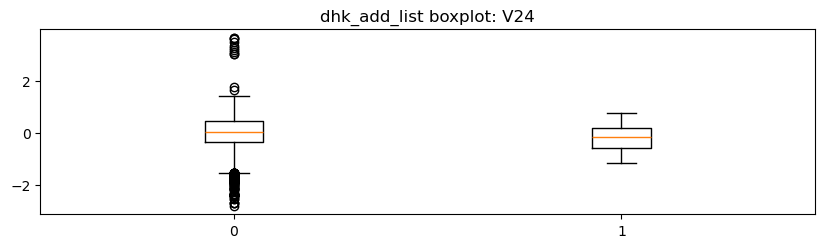

✅ saved: viz_checkpoints\20260112_114353\fig\dhk_add_list_boxplots.png


In [25]:
# =========================
# [VIZ-ADD-FEATS] dhk_add_list 분포/기여 검증
# Insert AFTER cell [19]
# =========================
def viz_add_features(dhk_list):
    df = ori_val_df.copy()
    feat_cols = list(df.columns[:-1])
    y = df["Class"].values

    idx = list(map(int, dhk_list))
    cols = [feat_cols[i] for i in idx if 0<=i<len(feat_cols)]
    mapping = pd.DataFrame({"idx": idx[:len(cols)], "col": cols})
    _save_csv(mapping, "tables/dhk_add_list_mapping.csv", index=False)
    print("dhk_add_list:", idx, "->", cols)

    # 박스플롯
    if cols:
        fig, axes = plt.subplots(len(cols), 1, figsize=(10, 2.4*len(cols)))
        if len(cols)==1:
            axes=[axes]
        for ax,c in zip(axes, cols):
            ax.boxplot([df.loc[y==0,c].values, df.loc[y==1,c].values], labels=["0","1"])
            ax.set_title(f"dhk_add_list boxplot: {c}")
        p = _save_fig(fig, "fig/dhk_add_list_boxplots.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

viz_add_features(dhk_add_list)


지금까지 선택한 변수들을 바탕으로 pacmap과 isolation forest를 돌려 예측합니다.

In [26]:
## pacmap과 isolation forest 3차 이용(1)
# pacmap과 isolation forest를 이용한 2차 예측
hhmm = 7
vlskffo_var = superior_var2 + dhk_add_list
what_val = vlskffo_var

for num in range(hhmm):
    embedding_3 = pacmap.PaCMAP(n_components=len(what_val), n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 600, verbose = True)
    pacmac_train_3 = embedding_3.fit_transform(np.array(train_df.iloc[:,what_val]), init="pca")
    pacmac_val_3 = embedding_3.transform(np.array(val_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))
    pacmac_test_3 = embedding_3.transform(np.array(test_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))

    pac_model_3 = IsolationForest(n_estimators=1000, contamination=0.00121, verbose=0)
    pac_model_3.fit(pacmac_train_3[:,[1,2,3]]) 

    if num == 0:
        train_pred_set_3 = pac_model_3.predict(pacmac_train_3[:,[1,2,3]]) # model prediction
        train_pred_set_3 = get_pred_label(train_pred_set_3)

        val_pred_set_3 = pac_model_3.predict(pacmac_val_3[:,[1,2,3]]) # model prediction
        val_pred_set_3 = get_pred_label(val_pred_set_3)

        test_pred_set_3 = pac_model_3.predict(pacmac_test_3[:,[1,2,3]]) # model prediction
        test_pred_set_3 = get_pred_label(test_pred_set_3)
    else:
        train_pred_3 = pac_model_3.predict(pacmac_train_3[:,[1,2,3]]) # model prediction
        train_pred_3 = get_pred_label(train_pred_3)
        train_pred_set_3 = train_pred_set_3 + train_pred_3

        val_pred_3 = pac_model_3.predict(pacmac_val_3[:,[1,2,3]]) # model prediction
        val_pred_3 = get_pred_label(val_pred_3)
        val_pred_set_3 = val_pred_set_3 + val_pred_3

        test_pred_3 = pac_model_3.predict(pacmac_test_3[:,[1,2,3]]) # model prediction
        test_pred_3 = get_pred_label(test_pred_3)
        test_pred_set_3 = test_pred_set_3 + test_pred_3

train_pred_set_3 = train_pred_set_3/hhmm
val_pred_set_3 = val_pred_set_3/hhmm
test_pred_set_3 = test_pred_set_3/hhmm

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2460811.000000
Iteration:   20, Loss: 2168022.500000
Iteration:   30, Loss: 2026805.750000
Iteration:   40, Loss: 1920199.125000
Iteration:   50, Loss: 1820136.000000
Iteration:   60, Loss: 1714895.875000
Iteration:   70, Loss: 1597241.625000
Iteration:   80, Loss: 1458339.125000
Iteration:   90, Loss: 1283051.000000
Iteration:  100, Loss: 1019591.375000
Iteration:  110, Loss: 1338851.500000
Iteration:  120, Loss: 1314127.375000
Iteration:  130, Loss: 1302604.000000
Iteration:  140, Loss: 1298646.000000
Iteration:  150, Loss: 1297736.875000
Iteration:  160, Loss: 1297746.625000
Iteration:  170, Loss: 1297809.7500

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461764.500000
Iteration:   20, Loss: 2168612.750000
Iteration:   30, Loss: 2027045.125000
Iteration:   40, Loss: 1920333.500000
Iteration:   50, Loss: 1820312.000000
Iteration:   60, Loss: 1714998.250000
Iteration:   70, Loss: 1597324.500000
Iteration:   80, Loss: 1458505.875000
Iteration:   90, Loss: 1283238.625000
Iteration:  100, Loss: 1019772.875000
Iteration:  110, Loss: 1338803.125000
Iteration:  120, Loss: 1314118.125000
Iteration:  130, Loss: 1302757.875000
Iteration:  140, Loss: 1298838.750000
Iteration:  150, Loss: 1298055.875000
Iteration:  160, Loss: 1297968.875000
Iteration:  170, Loss: 1298034.1250

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2460739.750000
Iteration:   20, Loss: 2168220.750000
Iteration:   30, Loss: 2026708.875000
Iteration:   40, Loss: 1920076.750000
Iteration:   50, Loss: 1820062.125000
Iteration:   60, Loss: 1714763.750000
Iteration:   70, Loss: 1597166.875000
Iteration:   80, Loss: 1458280.625000
Iteration:   90, Loss: 1282992.875000
Iteration:  100, Loss: 1019700.250000
Iteration:  110, Loss: 1338776.125000
Iteration:  120, Loss: 1314090.375000
Iteration:  130, Loss: 1302605.125000
Iteration:  140, Loss: 1298538.250000
Iteration:  150, Loss: 1297599.750000
Iteration:  160, Loss: 1297591.500000
Iteration:  170, Loss: 1297605.3750

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2460569.500000
Iteration:   20, Loss: 2168380.750000
Iteration:   30, Loss: 2026692.750000
Iteration:   40, Loss: 1920028.625000
Iteration:   50, Loss: 1820037.750000
Iteration:   60, Loss: 1714777.125000
Iteration:   70, Loss: 1597196.250000
Iteration:   80, Loss: 1458385.625000
Iteration:   90, Loss: 1283148.000000
Iteration:  100, Loss: 1019975.250000
Iteration:  110, Loss: 1339016.875000
Iteration:  120, Loss: 1314265.875000
Iteration:  130, Loss: 1302917.250000
Iteration:  140, Loss: 1298828.625000
Iteration:  150, Loss: 1297878.625000
Iteration:  160, Loss: 1297883.625000
Iteration:  170, Loss: 1297944.6250

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461343.250000
Iteration:   20, Loss: 2168599.250000
Iteration:   30, Loss: 2027041.125000
Iteration:   40, Loss: 1920282.500000
Iteration:   50, Loss: 1820151.000000
Iteration:   60, Loss: 1714874.750000
Iteration:   70, Loss: 1597290.750000
Iteration:   80, Loss: 1458425.375000
Iteration:   90, Loss: 1283161.250000
Iteration:  100, Loss: 1019860.500000
Iteration:  110, Loss: 1338962.500000
Iteration:  120, Loss: 1314220.875000
Iteration:  130, Loss: 1302655.125000
Iteration:  140, Loss: 1298503.000000
Iteration:  150, Loss: 1297564.000000
Iteration:  160, Loss: 1297575.250000
Iteration:  170, Loss: 1297630.3750

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461245.500000
Iteration:   20, Loss: 2168498.000000
Iteration:   30, Loss: 2027193.875000
Iteration:   40, Loss: 1920512.500000
Iteration:   50, Loss: 1820454.625000
Iteration:   60, Loss: 1715079.000000
Iteration:   70, Loss: 1597517.000000
Iteration:   80, Loss: 1458611.750000
Iteration:   90, Loss: 1283309.750000
Iteration:  100, Loss: 1019916.875000
Iteration:  110, Loss: 1338995.625000
Iteration:  120, Loss: 1314333.000000
Iteration:  130, Loss: 1302855.625000
Iteration:  140, Loss: 1298766.250000
Iteration:  150, Loss: 1297941.000000
Iteration:  160, Loss: 1297773.125000
Iteration:  170, Loss: 1297768.0000

Note: `n_components != 2` have not been thoroughly tested.


X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461146.000000
Iteration:   20, Loss: 2168649.000000
Iteration:   30, Loss: 2027362.125000
Iteration:   40, Loss: 1920572.500000
Iteration:   50, Loss: 1820458.000000
Iteration:   60, Loss: 1715292.000000
Iteration:   70, Loss: 1597531.500000
Iteration:   80, Loss: 1458588.250000
Iteration:   90, Loss: 1283295.875000
Iteration:  100, Loss: 1019784.375000
Iteration:  110, Loss: 1339080.500000
Iteration:  120, Loss: 1314458.625000
Iteration:  130, Loss: 1302744.500000
Iteration:  140, Loss: 1298731.875000
Iteration:  150, Loss: 1297727.250000
Iteration:  160, Loss: 1297777.250000
Iteration:  170, Loss: 1297815.5000

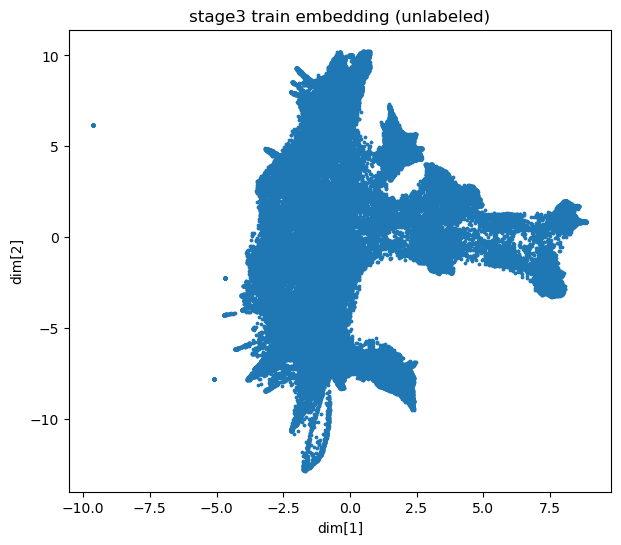

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_train_scatter2d.png


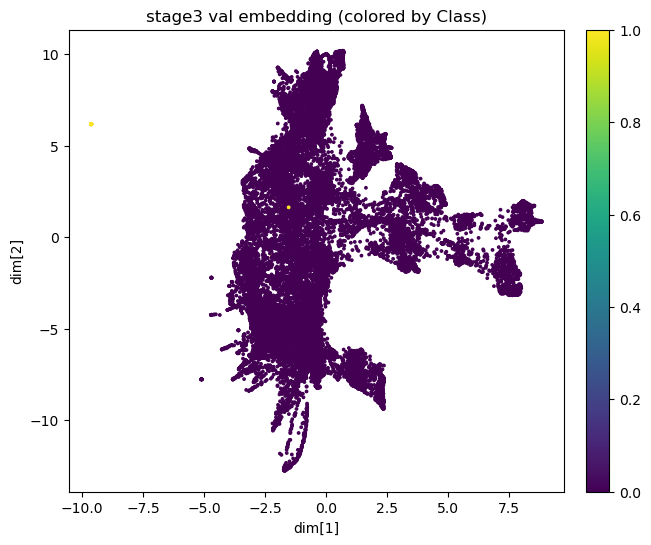

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_val_scatter2d_byClass.png


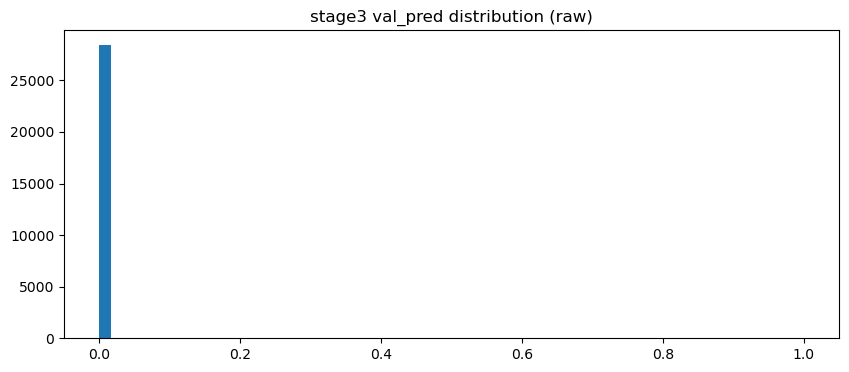

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_val_pred_hist.png

[stage3] confusion_matrix:
 [[28429     3]
 [    6    24]]
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998     28432
           1     0.8889    0.8000    0.8421        30

    accuracy                         0.9997     28462
   macro avg     0.9443    0.8999    0.9210     28462
weighted avg     0.9997    0.9997    0.9997     28462



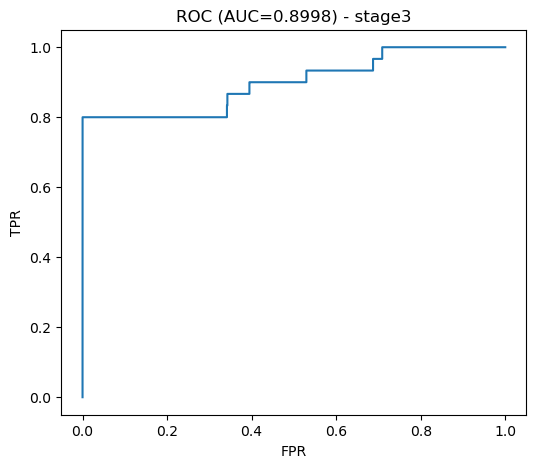

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_roc.png


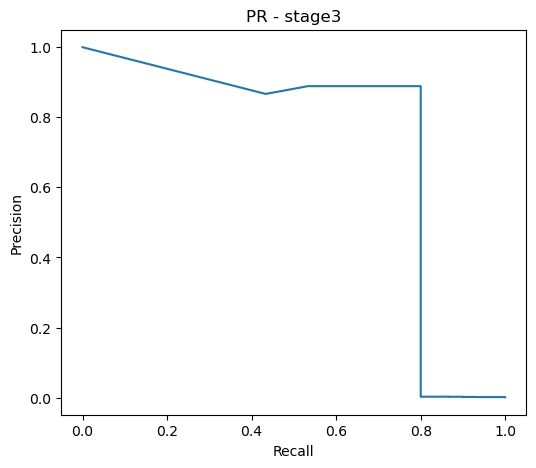

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_pr.png


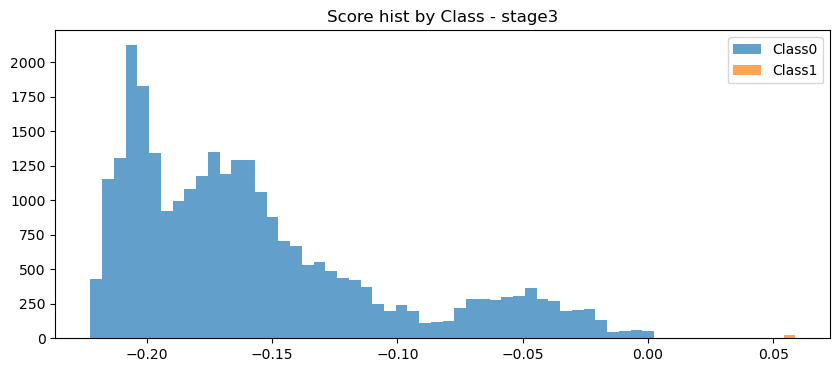

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_score_hist_by_class.png


In [27]:
# =========================
# [VIZ-EMB/PRED-3] stage-3 임베딩/예측 검증
# Insert AFTER cell [21]
# =========================
viz_stage_embedding_pred(
    "stage3",
    pacmac_train_3, pacmac_val_3, pacmac_test_3,
    train_pred_set_3, val_pred_set_3, test_pred_set_3,
    model=pac_model_3 if "pac_model_3" in globals() else None
)


In [28]:
## pacmap과 isolation forest 3차 이용(2)
val_score_3 = f1_score(ori_val_df['Class'], np.round(val_pred_set_3), average='macro')

print(f'Validation F1 Score : [{val_score_3}]')
print(classification_report(ori_val_df['Class'], np.round(val_pred_set_3)))
print(confusion_matrix(ori_val_df['Class'], np.round(val_pred_set_3)))

Validation F1 Score : [0.9209734995691701]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.89      0.80      0.84        30

    accuracy                           1.00     28462
   macro avg       0.94      0.90      0.92     28462
weighted avg       1.00      1.00      1.00     28462

[[28429     3]
 [    6    24]]


In [29]:
# =========================
# [VIZ-EVAL-3] stage-3 평가 출력 저장 강화
# Insert AFTER cell [22]
# =========================
y = ori_val_df["Class"].values
yhat = np.round(val_pred_set_3).astype(int)

report = classification_report(y, yhat, digits=4, zero_division=0, output_dict=True)
cm = confusion_matrix(y, yhat)

_save_json(report, "logs/stage3_classification_report.json")
_save_csv(pd.DataFrame(cm, index=["true0","true1"], columns=["pred0","pred1"]), "tables/stage3_cm_from_evalcell.csv", index=True)

print("✅ saved stage3 report/cm")


✅ saved stage3 report/cm


In [30]:
set(test_pred_set_3)

{np.float64(0.0),
 np.float64(0.14285714285714285),
 np.float64(0.2857142857142857),
 np.float64(0.7142857142857143),
 np.float64(0.8571428571428571),
 np.float64(1.0)}

In [31]:
## pacmap과 isolation forest 3차 이용(3)
# 2차 저장
chujung_train_2 = pd.DataFrame({'Class':np.round(train_pred_set_3)})
chujung_val_2 = pd.DataFrame({'Class':np.round(val_pred_set_3)})
chujung_test_2 = pd.DataFrame({'Class':np.round(test_pred_set_3)})

result_train_2 = pd.concat([train_df,chujung_train_2], axis=1)
result_val_2 = pd.concat([val_df,chujung_val_2], axis=1)
result_test_2 = pd.concat([test_df,chujung_test_2], axis=1)

result_train_2.to_csv('result_train_2.csv', index=False)
result_val_2.to_csv('result_val_2.csv', index=False)
result_test_2.to_csv('result_test_2.csv', index=False)

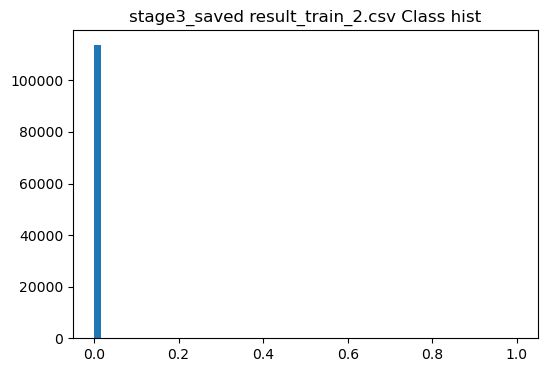

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_saved_result_train_2.csv_hist.png
✅ result_train_2.csv md5: d7c12f6021c596a055540037f88d972c shape: (113842, 31)


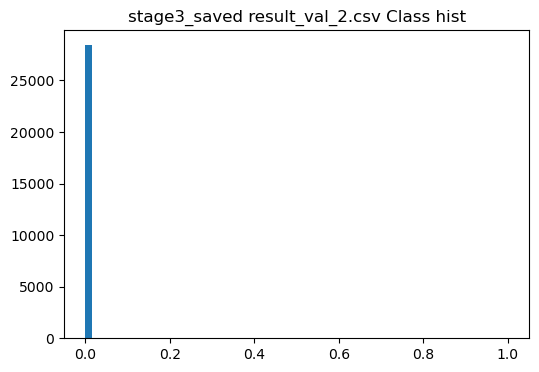

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_saved_result_val_2.csv_hist.png
✅ result_val_2.csv md5: 1b4b9cfd4f515aaa970559d2bb1c2d30 shape: (28462, 31)


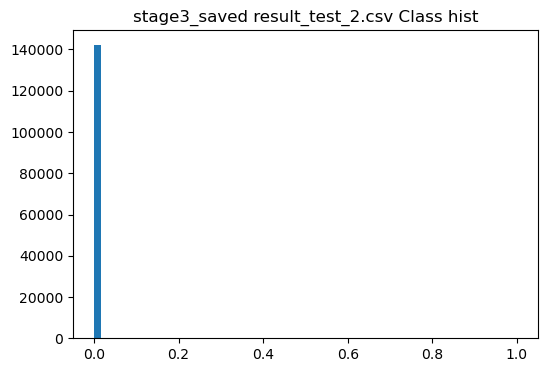

✅ saved: viz_checkpoints\20260112_114353\fig\stage3_saved_result_test_2.csv_hist.png
✅ result_test_2.csv md5: e0c315e73b4f750c22d53024e48dbc9d shape: (142503, 31)
✅ saved: logs/stage3_saved_file_meta.json


In [32]:
# =========================
# [VIZ-FILE-3] result_*_2.csv 무결성 검사/백업
# Insert AFTER cell [24]
# =========================
file_check_and_backup(
    ["result_train_2.csv", "result_val_2.csv", "result_test_2.csv"],
    "stage3_saved"
)


In [33]:
## pacmap과 isolation forest 3차 이용(4)
# 2차 불러오기 및 outlier된 dataset 모음
train_pred_set_3 = np.array(pd.read_csv('result_train_2.csv')['Class'])
val_pred_set_3 = np.array(pd.read_csv('result_val_2.csv')['Class'])
test_pred_set_3 = np.array(pd.read_csv('result_test_2.csv')['Class'])

one_train_df = train_df.iloc[np.where(np.round(train_pred_set_3) == 1)[0]]
one_val_df = ori_val_df.iloc[np.where(np.round(val_pred_set_3) == 1)[0]]
one_test_df = test_df.iloc[np.where(np.round(test_pred_set_3) == 1)[0]]

one_train_df: shape=(128, 30)
one_val_df: shape=(27, 31)
one_test_df: shape=(298, 30)
one_val_df class counts:
 Class
0     3
1    24
Name: count, dtype: int64


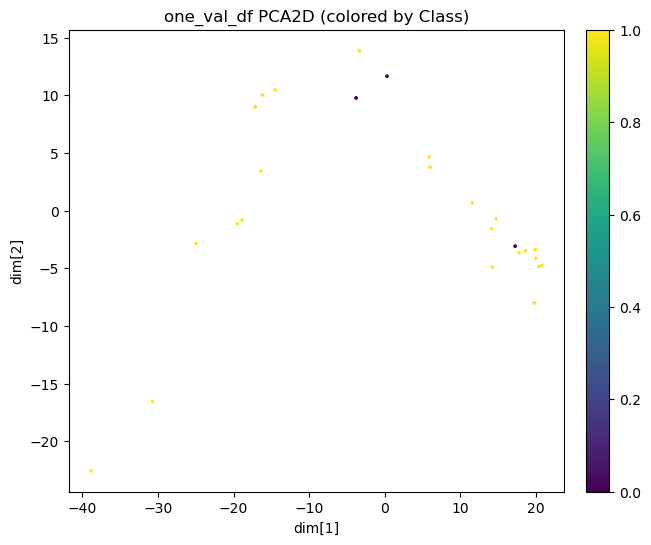

✅ saved: viz_checkpoints\20260112_114353\fig\one_val_pca2d.png


In [34]:
# =========================
# [VIZ-ONESET] one_* subset 구성 검증
# Insert AFTER cell [25]
# =========================
def viz_oneset():
    for name in ["one_train_df","one_val_df","one_test_df"]:
        if name not in globals():
            print("⚠️ missing:", name); continue
        df = globals()[name]
        print(f"{name}: shape={df.shape}")
        _save_csv(df.describe().transpose(), f"tables/{name}_describe.csv", index=True)

    # one_val_df는 Class 포함
    if "one_val_df" in globals() and "Class" in one_val_df.columns:
        vc = one_val_df["Class"].value_counts().sort_index()
        print("one_val_df class counts:\n", vc)
        _save_csv(vc.reset_index().rename(columns={"index":"Class","Class":"count"}), "tables/one_val_class_counts.csv", index=False)

    # 간단 PCA(2D)로 후보군 분포 보기 (sklearn PCA 사용)
    try:
        from sklearn.decomposition import PCA
        if "one_val_df" in globals():
            df = one_val_df.copy()
            y = df["Class"].values if "Class" in df.columns else None
            X = df[_feature_cols(df)].values if "Class" in df.columns else df.values
            Z = PCA(n_components=2).fit_transform(X)
            fig = _scatter2d(np.c_[np.zeros((len(Z),1)), Z], "one_val_df PCA2D (colored by Class)", color=y)
            p = _save_fig(fig, "fig/one_val_pca2d.png")
            plt.show(); plt.close(fig)
            print("✅ saved:", p)
    except Exception as e:
        print("⚠️ PCA scatter skip:", e)

viz_oneset()


저는 이에 더해 판별된 outlier들 중에 가짜를 도출하기로 생각했습니다.
역시 저는 변수를 선택하였고 validation dataset의 통계정보를 이용하였습니다. 이번엔 다른 방식으로 판별하고자 합니다. 개인적으로 저는 isolation forest를 사용함에도 표출이 안 된것은 특정 변수하에서는 가짜 outlier들이 진짜 outlier안에 숨어있다고 생각하였습니다. 그에 따라 KernelPCA를 이용해서 안쪽에 있는 가짜 outlier을 빼내고, pacmap을 사용한 다음, pca를 통해 좌표를 바꾸고, 극단값 중 몇몇개를 뽑아서 가짜 outlier라고 생각하였습니다. 우선, Validation dataset 내 ouliter로 판별된 것 중에서 실제 outlier들의 중위값과 가짜 outlier들의 중위값 검정 비교하였고, Validation dataset 내 ouliter로 판별된 것 중에서 실제 outlier들의 분산와 가짜 outlier 비율 체크해서 변수들을 확인하였습니다.

In [35]:
## outlier 중 가짜 판별(1)
# 변수 선택

rrr_df = []
for what_val in range(30):
    rrr_df.append(ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],what_val],one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],what_val]).pvalue)

rrr_idx = np.where(np.array(rrr_df) > 0.05)[0]

qqq_df = []
for what_val in rrr_idx:
    qqq_df.append(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],what_val].var()/one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],what_val].var())

new_born_idx = np.argsort(qqq_df)[:5]

   idx  col
0   20  V21
1   23  V24
2   14  V15
3    3   V4
4   18  V19


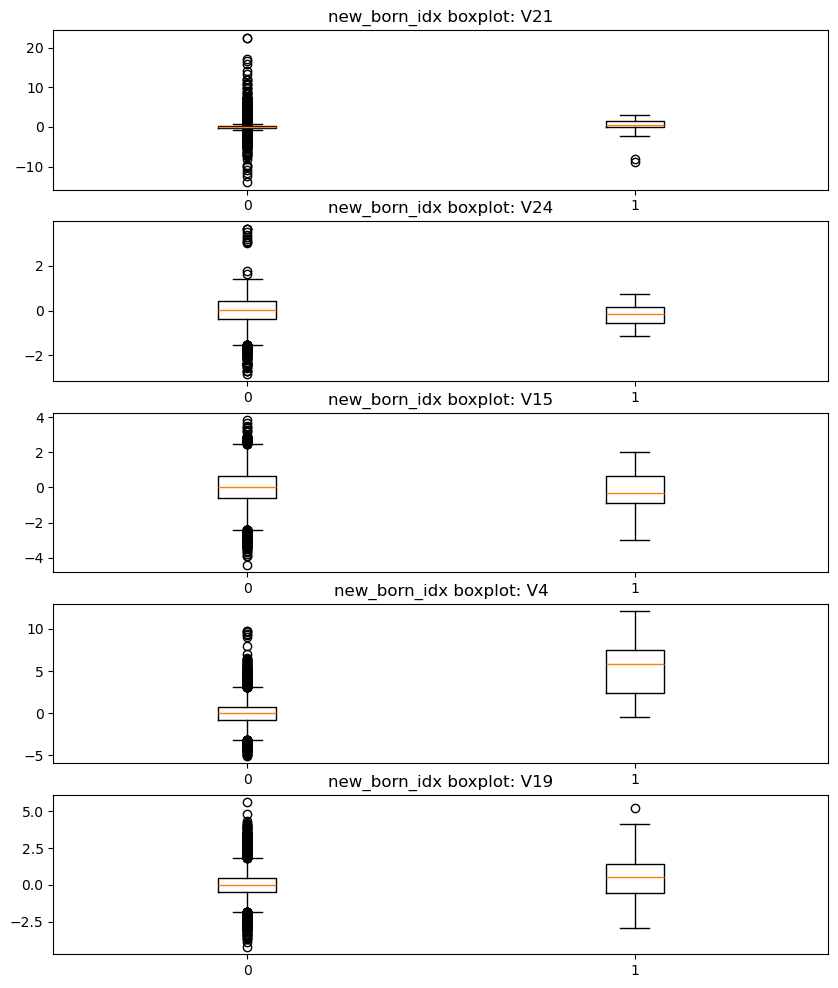

✅ saved: viz_checkpoints\20260112_114353\fig\new_born_idx_boxplots.png


In [36]:
# =========================
# [VIZ-FAKESEL] new_born_idx 선택 결과 검증
# Insert AFTER cell [27]
# =========================
def viz_fake_feature_selection():
    if "new_born_idx" not in globals():
        print("⚠️ new_born_idx missing"); return
    df = ori_val_df.copy()
    feat_cols = list(df.columns[:-1])
    y = df["Class"].values

    idx = list(map(int, new_born_idx))
    cols = [feat_cols[i] for i in idx if 0<=i<len(feat_cols)]
    mapping = pd.DataFrame({"idx": idx[:len(cols)], "col": cols})
    _save_csv(mapping, "tables/new_born_idx_mapping.csv", index=False)
    print(mapping)

    # 박스플롯
    if cols:
        fig, axes = plt.subplots(len(cols), 1, figsize=(10, 2.4*len(cols)))
        if len(cols)==1: axes=[axes]
        for ax,c in zip(axes, cols):
            ax.boxplot([df.loc[y==0,c].values, df.loc[y==1,c].values], labels=["0","1"])
            ax.set_title(f"new_born_idx boxplot: {c}")
        p = _save_fig(fig, "fig/new_born_idx_boxplots.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

viz_fake_feature_selection()


In [37]:
print(new_born_idx)

[20 23 14  3 18]


다음으로 가짜 판별하는데 있어서 위에서 이야기한 그대로 바탕으로 진행하였습니다. 가짜 outlier인지 아닌지 판별하는데 있어서 Validation set의 통계정보와 wilcoxon rank sum test를 이용하였습니다. 

In [38]:
## outlier 중 가짜 판별(2)
# 판별
transformer = KernelPCA(n_components=5, kernel='rbf')
hhhhh = new_born_idx
can_sepearate = np.argsort(rrr_df)[0]

X_transformed = transformer.fit_transform(one_train_df.iloc[:,hhhhh])
X1_transformed = transformer.transform(one_val_df.iloc[:,hhhhh])
X2_transformed = transformer.transform(one_test_df.iloc[:,hhhhh])

# kernel pca 후 1에서 0 찾기 by pacmap 그후 판별
hhmm = 201
skip_count = 0

contamin = 0.0725
making_set = 0

for num in range(hhmm):
    embedding1010 = pacmap.PaCMAP(n_components=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = False)
    pacmac_train1010 = embedding1010.fit_transform(X_transformed, init="pca")
    pacmac_val1010 = embedding1010.transform(X1_transformed, basis=X_transformed)
    pacmac_test1010 = embedding1010.transform(X2_transformed, basis=X_transformed)

    # 그냥 pca
    pcawow = PCA(n_components = 3) # 주성분을 몇개로 할지 결정
    pca_train_wow = pcawow.fit_transform(pacmac_train1010)
    pca_train_wow = pd.DataFrame(data=pca_train_wow)

    pca_val_wow = pcawow.transform(pacmac_val1010)
    pca_val_wow = pd.DataFrame(data=pca_val_wow)

    pca_test_wow = pcawow.transform(pacmac_test1010)
    pca_test_wow = pd.DataFrame(data=pca_test_wow)

    rlwns = int(contamin*len(pca_train_wow))
    thtn = contamin*len(pca_train_wow) - rlwns
    
    if making_set == 0:
        max_part_zero = 0
        max_part_one = 0
        max_what = 100
        
        # PC 축을 설정하고 좌 또는 우 극단값을 찾고 해당하는 중위값이 실제 outlier들의 중위값인지 체크
        for jrj in range(6):
            val_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})       

            if jrj % 2 == 0:                
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nlargest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nlargest((rlwns+1)).iloc[(rlwns)]

                val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn) ))] = 0
            else:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nsmallest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

                val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

            ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_set_1010['Class'] == 1)[0],can_sepearate]).pvalue
            ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_set_1010['Class'] == 0)[0],can_sepearate]).pvalue

            if np.isnan(ranksum_pval_ed_zero):
                continue
            
            if max_part_zero <= ranksum_pval_ed_zero:
                max_part_zero = ranksum_pval_ed_zero
            if max_part_one <= ranksum_pval_ed_one:
                max_part_one = ranksum_pval_ed_one

            if max_part_zero >= 0.5:
                if max_part_one >= 0.5:
                    max_what = jrj
                    break

        if max_what == 100:
            skip_count += 1
            continue
        making_set += 10
        
        # 체크 후 해당하는 축으로 가짜 outlier 판별
        val_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

        if max_what % 2 == 0:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nlargest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nlargest((rlwns+1)).iloc[(rlwns)]

            val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        else:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nsmallest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

            val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        
        train_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_train_wow))})

        if max_what % 2 == 0:
            train_pred_set_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            train_pred_set_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0   

        test_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_test_wow))})

        if max_what % 2 == 0:
            test_pred_set_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            test_pred_set_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0 

    else:
        max_part_zero = 0
        max_part_one = 0
        max_what = 100
        
        # PC 축을 설정하고 좌 또는 우 극단값을 찾고 해당하는 중위값이 실제 outlier들의 중위값인지 체크
        for jrj in range(6):
            val_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

            if jrj % 2 == 0:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nlargest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nlargest((rlwns+1)).iloc[(rlwns)]

                val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn) ))] = 0
            else:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nsmallest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

                val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

            ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 1)[0],can_sepearate]).pvalue
            ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 0)[0],can_sepearate]).pvalue

            if np.isnan(ranksum_pval_ed_zero):
                continue
            
            if max_part_zero <= ranksum_pval_ed_zero:
                max_part_zero = ranksum_pval_ed_zero
            if max_part_one <= ranksum_pval_ed_one:
                max_part_one = ranksum_pval_ed_one

            if max_part_zero >= 0.5:
                if max_part_one >= 0.5:
                    max_what = jrj
                    break
        
        if max_what == 100:
            skip_count += 1
            continue
        
        # 체크 후 해당하는 축으로 가짜 outlier 판별
        val_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

        if max_what % 2 == 0:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nlargest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nlargest((rlwns+1)).iloc[(rlwns)]

            val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nsmallest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

            val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 1)[0],can_sepearate]).pvalue
        ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 0)[0],can_sepearate]).pvalue

        val_pred_set_1010 = val_pred_set_1010 + val_pred_1010

        train_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_train_wow))})

        if max_what % 2 == 0:
            train_pred_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            train_pred_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0   

        train_pred_set_1010 = train_pred_set_1010 + train_pred_1010

        test_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_test_wow))})

        if max_what % 2 == 0:
            test_pred_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            test_pred_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0   

        test_pred_set_1010 = test_pred_set_1010 + test_pred_1010

train_pred_set_1010 = train_pred_set_1010/(hhmm- skip_count)
val_pred_set_1010 = val_pred_set_1010/(hhmm-skip_count)
test_pred_set_1010 = test_pred_set_1010/(hhmm-skip_count)

Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly tested.
Note: `n_components != 2` have not been thoroughly teste

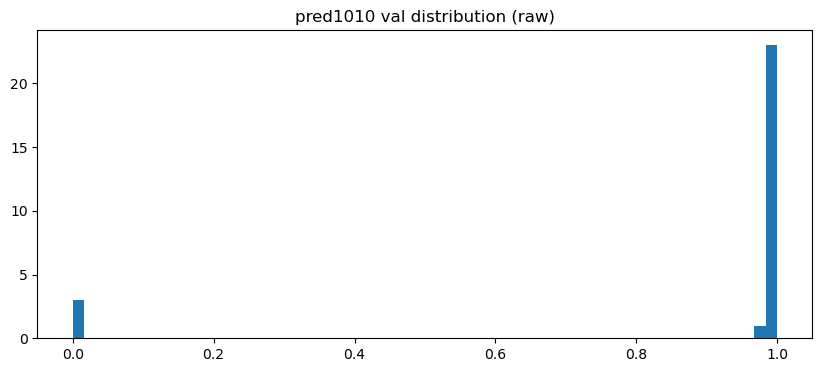

✅ saved: viz_checkpoints\20260112_114353\fig\pred1010_val_hist.png


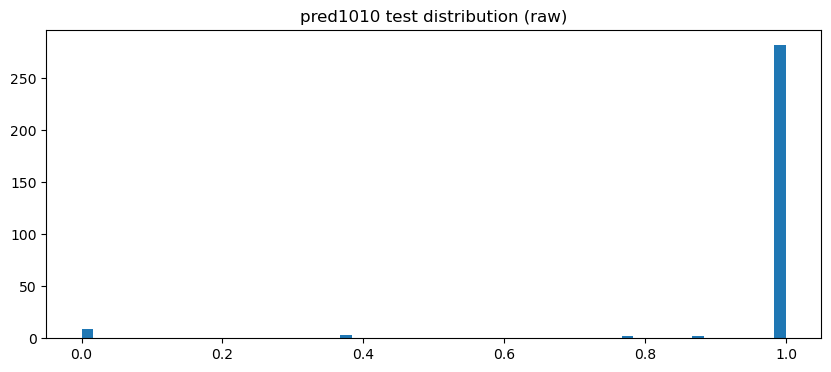

✅ saved: viz_checkpoints\20260112_114353\fig\pred1010_test_hist.png


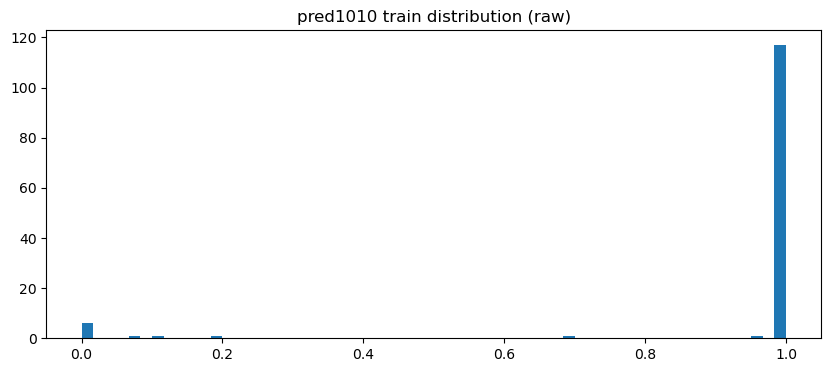

✅ saved: viz_checkpoints\20260112_114353\fig\pred1010_train_hist.png
✅ subset index resolve: one_val_df.index (assumed original positions)

[pred1010 SUBSET] confusion_matrix:
 [[ 3  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     1.0000    1.0000    1.0000        24

    accuracy                         1.0000        27
   macro avg     1.0000    1.0000    1.0000        27
weighted avg     1.0000    1.0000    1.0000        27


[PIPELINE VAL AFTER 1010] confusion_matrix:
 [[28432     0]
 [    6    24]]
              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999     28432
           1     1.0000    0.8000    0.8889        30

    accuracy                         0.9998     28462
   macro avg     0.9999    0.9000    0.9444     28462
weighted avg     0.9998    0.9998    0.9998     28462

✅ saved: tables/pred1010_subset_cm.csv, logs/pred1010_metrics_fixed.json


In [41]:
# =========================
# [VIZ-KPCA/PRED-1010] pred_set_1010 최종 검증 (FIXED)
# Insert AFTER cell [30]
# =========================
def _resolve_one_val_indices(va_len: int):
    """
    val_pred_set_1010(=va)가 어떤 샘플들에 대한 예측인지 '원본 val 인덱스'를 찾아준다.
    우선순위:
      1) one_val_df가 있으면 ID 매핑 or index 사용
      2) val_pred_set_3가 있으면 round==1 인덱스 사용
    """
    # 1) one_val_df 기반
    if "one_val_df" in globals() and isinstance(one_val_df, pd.DataFrame) and len(one_val_df) == va_len:
        # (1-a) ID로 매핑 (가장 안전)
        if "ID" in one_val_df.columns and "ID" in ori_val_df.columns:
            id_to_pos = {int(i): p for p, i in enumerate(ori_val_df["ID"].values)}
            idx = []
            ok = True
            for i in one_val_df["ID"].values:
                ii = int(i)
                if ii not in id_to_pos:
                    ok = False
                    break
                idx.append(id_to_pos[ii])
            if ok and len(idx) == va_len:
                return np.array(idx, dtype=int), "one_val_df.ID -> ori_val_df position"

        # (1-b) index가 원본 인덱스일 가능성
        # (reset_index 안 했다면 one_val_df.index가 원본 위치일 수 있음)
        idx = one_val_df.index.values
        if np.issubdtype(idx.dtype, np.integer) and idx.min() >= 0 and idx.max() < len(ori_val_df) and len(idx) == va_len:
            return idx.astype(int), "one_val_df.index (assumed original positions)"

    # 2) val_pred_set_3 기반 (원본 코드에서 보통 one_*는 여기서 만들어짐)
    if "val_pred_set_3" in globals():
        idx = np.where(np.round(np.asarray(val_pred_set_3).reshape(-1)).astype(int) == 1)[0]
        if len(idx) == va_len:
            return idx.astype(int), "np.where(round(val_pred_set_3)==1)"

    return None, "FAILED"


def viz_pred1010_fixed(thr=0.5):
    needed = ["train_pred_set_1010", "val_pred_set_1010", "test_pred_set_1010"]
    for n in needed:
        if n not in globals():
            print("⚠️ missing:", n)
            return

    tr = np.asarray(train_pred_set_1010).reshape(-1)
    va = np.asarray(val_pred_set_1010).reshape(-1)
    te = np.asarray(test_pred_set_1010).reshape(-1)

    # 저장
    _save_npy(tr, "arrays/pred1010_train.npy")
    _save_npy(va, "arrays/pred1010_val.npy")
    _save_npy(te, "arrays/pred1010_test.npy")

    # 분포 저장
    for arr, tag in [(va, "val"), (te, "test"), (tr, "train")]:
        fig = _hist(arr, f"pred1010 {tag} distribution (raw)")
        p = _save_fig(fig, f"fig/pred1010_{tag}_hist.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

    # --- 핵심: va는 'subset' 예측이므로 subset index를 복원 ---
    idx, how = _resolve_one_val_indices(len(va))
    print(f"✅ subset index resolve: {how}")

    if idx is None:
        print("❌ subset 인덱스를 복원하지 못했어.")
        print("   one_val_df / val_pred_set_3 존재 여부와 길이(=len(val_pred_set_1010))를 확인해줘.")
        return

    # subset 라벨 & subset 예측
    y_all = ori_val_df["Class"].values
    y_sub = y_all[idx]
    # 원본 코드가 round() 기반이라면 round 사용, voting(0~1)이면 threshold 사용 가능
    yhat_sub = np.round(va).astype(int)  # 기본: 원본 방식
    # 필요하면 아래로 변경 가능:
    # yhat_sub = (va >= thr).astype(int)

    # (1) subset 기준 성능 (1010 자체가 맞는지)
    cm_sub = confusion_matrix(y_sub, yhat_sub)
    print("\n[pred1010 SUBSET] confusion_matrix:\n", cm_sub)
    print(classification_report(y_sub, yhat_sub, digits=4, zero_division=0))

    _save_csv(pd.DataFrame(cm_sub, index=["true0","true1"], columns=["pred0","pred1"]),
              "tables/pred1010_subset_cm.csv", index=True)

    # (2) 전체 val로 확장해서 "파이프라인 최종 예측"도 평가
    if "val_pred_set_3" in globals():
        # stage3 결과(0/1)에서 subset 구간만 1010 결과로 교체
        val_stage3 = np.round(np.asarray(val_pred_set_3).reshape(-1)).astype(int)
        val_after = val_stage3.copy()
        val_after[idx] = yhat_sub  # 1010이 '진짜 outlier=1'만 남긴다면 이게 정답 패턴

        cm_all = confusion_matrix(y_all, val_after)
        print("\n[PIPELINE VAL AFTER 1010] confusion_matrix:\n", cm_all)
        print(classification_report(y_all, val_after, digits=4, zero_division=0))

        _save_csv(pd.DataFrame(cm_all, index=["true0","true1"], columns=["pred0","pred1"]),
                  "tables/pipeline_val_after1010_cm.csv", index=True)

        _save_json({
            "subset_resolve_how": how,
            "subset_len": int(len(idx)),
            "val_all_len": int(len(y_all)),
            "subset_pos_rate_pred": float(np.mean(yhat_sub == 1)),
            "subset_f1_macro": float(f1_score(y_sub, yhat_sub, average="macro")),
            "pipeline_f1_macro": float(f1_score(y_all, val_after, average="macro")),
            "pipeline_pos_rate": float(np.mean(val_after == 1)),
            "test_pos_rate_round": float(np.mean(np.round(te).astype(int) == 1)),
            "train_pos_rate_round": float(np.mean(np.round(tr).astype(int) == 1)),
        }, "logs/pred1010_metrics_fixed.json")

        # 확장된 예측 벡터도 저장(나중에 분석/그림용)
        _save_npy(val_after, "arrays/val_pred_after1010.npy")

    else:
        _save_json({
            "subset_resolve_how": how,
            "subset_len": int(len(idx)),
            "val_all_len": int(len(y_all)),
            "subset_pos_rate_pred": float(np.mean(yhat_sub == 1)),
            "subset_f1_macro": float(f1_score(y_sub, yhat_sub, average="macro")),
            "test_pos_rate_round": float(np.mean(np.round(te).astype(int) == 1)),
            "train_pos_rate_round": float(np.mean(np.round(tr).astype(int) == 1)),
        }, "logs/pred1010_metrics_fixed.json")

    print("✅ saved: tables/pred1010_subset_cm.csv, logs/pred1010_metrics_fixed.json")

viz_pred1010_fixed()


In [42]:
## 최종 확인
# voting해서 50% 이상 1이면 1로, 반대면 0으로
final_one_train_df = one_train_df.iloc[np.where(np.round(train_pred_set_1010['Class']) == 1)[0]]
final_one_val_df = one_val_df.iloc[np.where(np.round(val_pred_set_1010['Class']) == 1)[0]]
final_one_test_df = one_test_df.iloc[np.where(np.round(test_pred_set_1010['Class']) == 1)[0]]

# validation score 확인
chujung_train2 = pd.DataFrame({'Class':np.repeat(0,len(train_df))})
chujung_val2 = pd.DataFrame({'pre_Class':np.repeat(0,len(val_df))})
chujung_test2 = pd.DataFrame({'Class':np.repeat(0,len(test_df))})

chujung_train2.iloc[final_one_train_df.index,0] = 1
chujung_val2.iloc[final_one_val_df.index,0] = 1
chujung_test2.iloc[final_one_test_df.index,0] = 1

sec_result_train = pd.concat([train_df,chujung_train2], axis=1)
sec_result_val = pd.concat([val_df,chujung_val2], axis=1)
sec_result_test = pd.concat([test_df,chujung_test2], axis=1)

print('F1-score',f1_score(sec_result_val['pre_Class'], val_class, average='macro'))
print(confusion_matrix(sec_result_val['pre_Class'], val_class))
print(classification_report(sec_result_val['pre_Class'], val_class))

# 저장
submit = pd.read_csv('sample_submission.csv')
submit['Class'] = 0

submit.iloc[final_one_test_df.index,1] = 1
submit.iloc[final_one_test_df.index,1]

submit.to_csv('result_submit.csv', index=False)

F1-score 0.9443916925541683
[[28432     6]
 [    0    24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28438
           1       0.80      1.00      0.89        24

    accuracy                           1.00     28462
   macro avg       0.90      1.00      0.94     28462
weighted avg       1.00      1.00      1.00     28462



final_submit shape: (142503, 2) columns: ['ID', 'Class']
final pos_rate: 0.002006975291748244


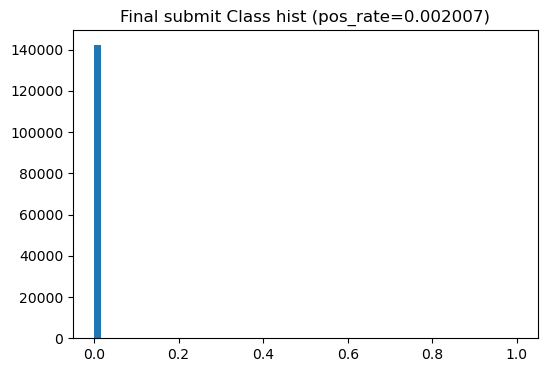

✅ saved: viz_checkpoints\20260112_114353\fig\final_submit_class_hist.png
✅ backed up to: C:\Users\xrtwin\Desktop\신용카드 사기 거래 탐지 AI 경진대회 월간 데이콘\open\viz_checkpoints\20260112_114353\backup\result_submit.csv


In [43]:
# =========================
# [VIZ-FINAL] 최종 제출물 검증/백업
# Insert AFTER cell [31]
# =========================
def viz_final_submit():
    # 원본은 result_submit.csv를 저장함
    src = "result_submit.csv"
    if not os.path.exists(src):
        print("⚠️ result_submit.csv not found")
        return

    df = pd.read_csv(src)
    print("final_submit shape:", df.shape, "columns:", df.columns.tolist())

    if "Class" in df.columns:
        pr = float(np.mean(df["Class"].values==1))
        print("final pos_rate:", pr)
        _save_json({"final_pos_rate": pr, "n": int(len(df))}, "logs/final_submit_summary.json")

        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(df["Class"].values, bins=60)
        ax.set_title(f"Final submit Class hist (pos_rate={pr:.6f})")
        p = _save_fig(fig, "fig/final_submit_class_hist.png")
        plt.show(); plt.close(fig)
        print("✅ saved:", p)

    # 백업 복사
    shutil.copy(src, VIZ_ROOT/"backup"/src)
    print("✅ backed up to:", (VIZ_ROOT/"backup"/src).resolve())

viz_final_submit()
